Программа обработки сигналов акустической эмиссии. Программа использует данные, сформированные при циклическом испытании плоских образцов. Сиганлы акустической эмисии регистрировались двумя преобразователями, установленными на образце.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker

Функция расчета значений временных интервалов между импульсами. Функция принимает столбец DataFrame, содержащий значения времени регистрации сигналов акустической эмиссии. Функция выдает столбец DataFrame, содержащий значения временных интервалов между сигналами акустической эмиссии.    

In [2]:
def delta_t(frame):
    frame.index = range(len(frame))
    duble_frame = frame.copy()
    del duble_frame[0]
    duble_frame.index = range(len(duble_frame))
    del frame[len(frame) - 1]
    delta_time = duble_frame - frame
    delta_time.index = range(1, len(frame) + 1)
    return delta_time

Функция расчета скользящей корреляции. Функция принимает столбец DataFrame. Функция выдает столбец DataFrame, содержащий значения коэффициента корреляции.

In [3]:
def corr_chart(data_01, data_02):
    change_01 = data_01.pct_change()
    change_02 = data_02.pct_change()
    return change_02.rolling(100, min_periods=5).corr(change_01)

Функция фильтрации выбросов. Функция принимает объект DataFrame и номер канала. Функция рассчитывает первый Q1 и третий квартиль Q3 и отбрасывает данные, превышающие верхнюю границу Q1 + 1.5(Q3-Q1). Функция возвращает объект DataFrame, очищенный от выбросов. 

In [4]:
def function_no_outlier(data, num_of_ch):
    first_quartile = data.loc[data['Number of channel'] == num_of_ch]['Interval'].quantile(0.25)
    third_quartile = data.loc[data['Number of channel'] == num_of_ch]['Interval'].quantile(0.75)
    Upper_limit = first_quartile + 1.5*(third_quartile - first_quartile)
    drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index
    data_no_outlier = data.drop(drop_index)
    return data_no_outlier

Считывание данных из текстового файла.

In [5]:
f = open(r'C:\Users\homepc\Documents\Pyton\aem14_01_13#02_AE.txt', 'r', encoding="utf-16")

Формирование объекта DataFrame из файла данных.

In [6]:
line = f.readline()  
s = []
col = ['Date', 'Time', 'mks', 'Time relative', 'Number of channel', 'Type', 'Amplitude, ADC', 'Amplitude, dB', 'Amplitude, mkV',
       'Amplitude/Counts, mkV', 'Ln(Amplitude)/Counts', 'Energy, J', 'Energy, dB', 'Energy MARSE', 'Duration', 'Rise time', 
       'Counts', 'Counts/Duration, kHz', 'Flags']
frame = pd.DataFrame(s, index = col)
i = 0
while line != '':
    s = line.split()
    frame[i] = s
    i += 1
    line = f.readline()
f.close()

Функция формирует строку, содержащую информацию о времени регистрации сигнала акустической эмиссии, суммируя текстовую информацию в стобцах 'Date', 'Time', 'mks'. Далее строка преобразуется в объект Datetime.  

In [7]:
def f(x):
    date = x[0] + ' ' + x[1] + '.' + x[2]
    return datetime.strptime(date, '%d.%m.%y %H:%M:%S.%f')

Формирование в столбце 'Time' объекта DataFrame данных о времени регистрации сигналов акустической эмиссии в формате Datetime. 

In [8]:
time = frame.apply(f)
data = frame.T
data['Time'] = time

Удаление из объекта DataFrame столбцов, содержащих информацию, не используемую в анализе

In [9]:
frame = data.drop(['Date', 'mks', 'Type', 'Flags'], axis = 1)

Расчет временных интервалов между сигналами акустической эмиссии для 1 и 2 каналов регистрации с помощью функции delta_t. Формирование объекта DataFrame, содержащего значения временных интервалов между сигналами. Индекс объекта DataFrame начинается со второго зарегистрированного сигнала.

In [10]:
f = lambda x: x.seconds + x.microseconds/1000000
data_t01 = delta_t(frame[frame['Number of channel'] == '01']['Time']).apply(f).to_frame(name = 'Interval')
data_t02 = delta_t(frame[frame['Number of channel'] == '02']['Time']).apply(f).to_frame(name = 'Interval')
data_t01.index = frame.loc[frame['Number of channel'] == '01'].index[1:]
data_t02.index = frame.loc[frame['Number of channel'] == '02'].index[1:]

Объединение данных с объектом DataFrame, содержащим значения временных интервалов между сигналами для 1 канала регистрации, запись в фрейм данных значений временных интервалов между сигналами для 2 канала регистрации

In [11]:
frame = pd.concat([frame, data_t01], axis = 1)
frame.loc[frame['Number of channel'] == '02', 'Interval'] = data_t02

Преобразование текстовых данных в числовой формат

In [12]:
f1 = lambda x: float(x)
for row in ['Time relative', 'Amplitude, ADC', 'Amplitude, dB', 'Amplitude, mkV', 'Amplitude/Counts, mkV', 
            'Ln(Amplitude)/Counts', 'Energy, J', 'Energy, dB', 'Energy MARSE', 'Duration', 'Rise time', 'Counts',
            'Counts/Duration, kHz']:
    frame[row] = frame[row].apply(f1)

Удаление строк, содержащих выбросы в столбце 'Interval' с помощью функции function_no_outlier. Формирование нового объекта DataFrame, не содержащего строк с выбросами в столбце 'Interval'

In [13]:
frame_no_outlier_01 = function_no_outlier(frame, '01')
frame_no_outlier = function_no_outlier(frame_no_outlier_01, '02')

<ipython-input-4-d7fdc3f1adc5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index
<ipython-input-4-d7fdc3f1adc5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drop_index = data.loc[data['Number of channel'] == num_of_ch][data.Interval > Upper_limit].index


Построение графика изменения значений временных интервалов между сигналами акустической эмиссии от времени для каждого канала

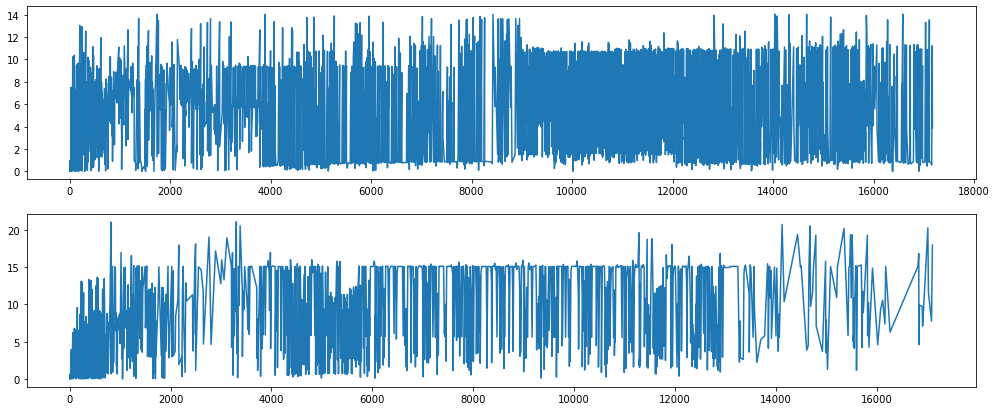

In [14]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
locator = matplotlib.ticker.MaxNLocator()
ax1.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Time relative'], 
         frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'])
ax1.xaxis.set_major_locator(locator)
ax2.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Time relative'], 
         frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'])
ax2.xaxis.set_major_locator(locator)

Построение графика корреляции между значениями интервалов между сигналами акустической эмиссии и амплитудой сигналов для каждого канала для объекта DataFrame, не содержащего выбросы, и полного объекта DataFrame

<ipython-input-15-4d45c8cf8b16>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2, 1, 1)
<ipython-input-15-4d45c8cf8b16>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = fig.add_subplot(2, 1, 2)


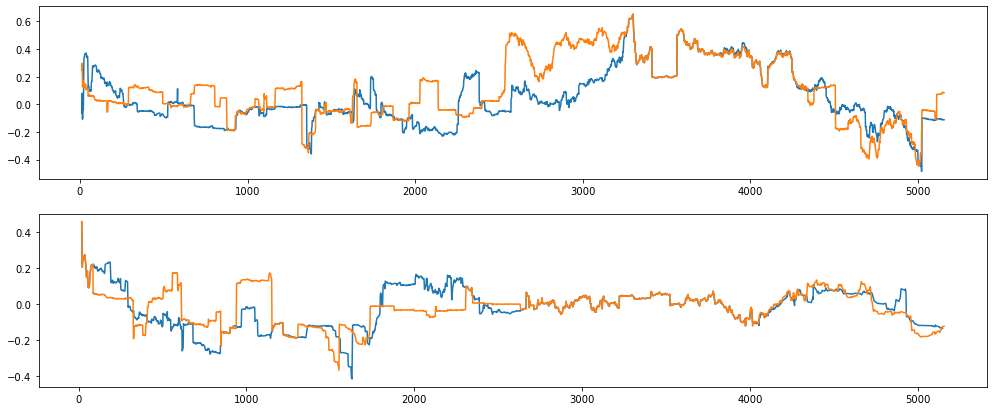

In [15]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(corr_chart(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'],
                   frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Amplitude, dB']))
ax2.plot(corr_chart(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'],
                   frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Amplitude, dB']))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(corr_chart(frame.loc[frame['Number of channel'] == '01']['Interval'],
                   frame.loc[frame['Number of channel'] == '01']['Amplitude, dB']))
ax2.plot(corr_chart(frame.loc[frame['Number of channel'] == '02']['Interval'],
                   frame.loc[frame['Number of channel'] == '02']['Amplitude, dB']))

Построение графика зависимости значений временных интервалов между сигналами акустической эмиссии от амплитуды сигналов для каждого канала

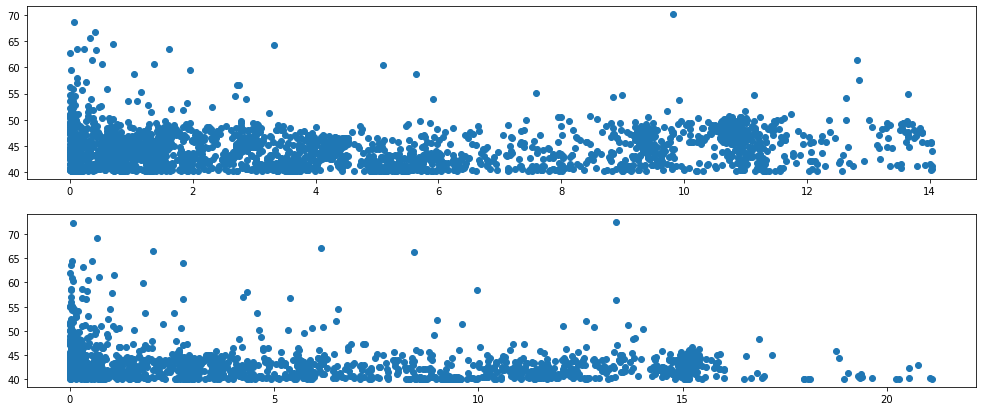

In [16]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Amplitude, dB'])
ax2.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Amplitude, dB'])

Построение графика зависимости значений временных интервалов между сигналами акустической эмиссии от амплитуды сигналов для каждого канала для объекта DataFrame, не отфильтрованного по выбрасам в столбце 'Interval'

(-5.0, 20.0)

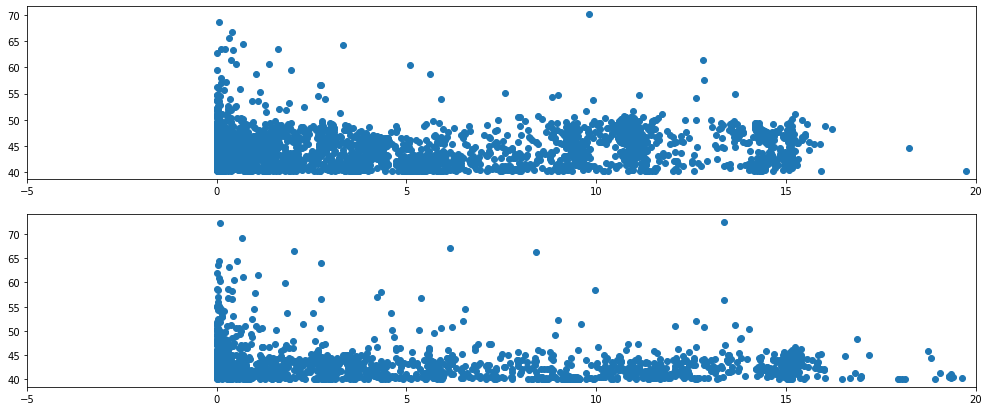

In [17]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.scatter(frame.loc[frame['Number of channel'] == '01']['Interval'], 
           frame.loc[frame['Number of channel'] == '01']['Amplitude, dB'])
ax1.set_xlim([-5, 20])
ax2.scatter(frame.loc[frame['Number of channel'] == '02']['Interval'], 
           frame.loc[frame['Number of channel'] == '02']['Amplitude, dB'])
ax2.set_xlim([-5, 20])

Построение графика распределения значений интервалов между сигналами акустической эмиссии

(array([533., 235., 169.,  82., 150., 137.,  85., 367.,  11.,  14.]),
 array([1.34500000e-03, 2.11284630e+00, 4.22434760e+00, 6.33584890e+00,
        8.44735020e+00, 1.05588515e+01, 1.26703528e+01, 1.47818541e+01,
        1.68933554e+01, 1.90048567e+01, 2.11163580e+01]),
 <BarContainer object of 10 artists>)

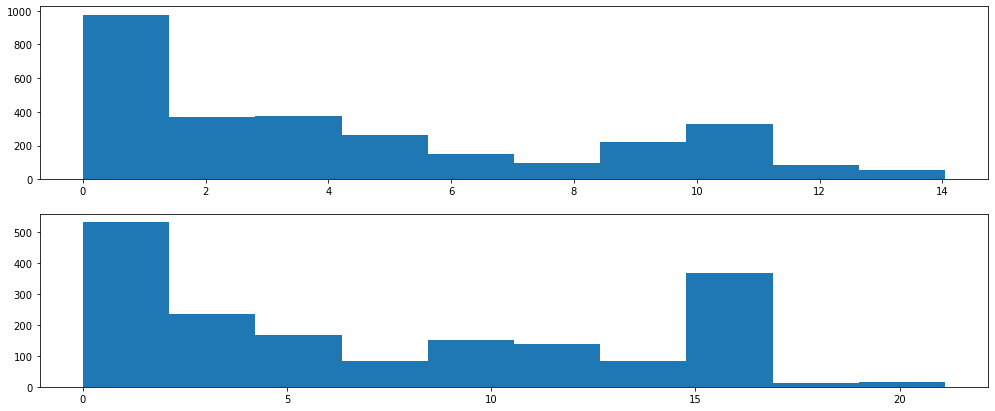

In [18]:
fig = plt.figure()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.hist(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'])
ax2.hist(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'])

Построение графика изменения значения временного инварианта от времени для отфильтрованного по выбросам объекта DataFrame. Временной инвариант - это отношение стандартного отклонения временных интервалов между сигналами акустической эмиссии к их среднему значению. Для пуассоновского потока актов акустической эмиссии временной интервал имеет устойчивое значение, равное 1.

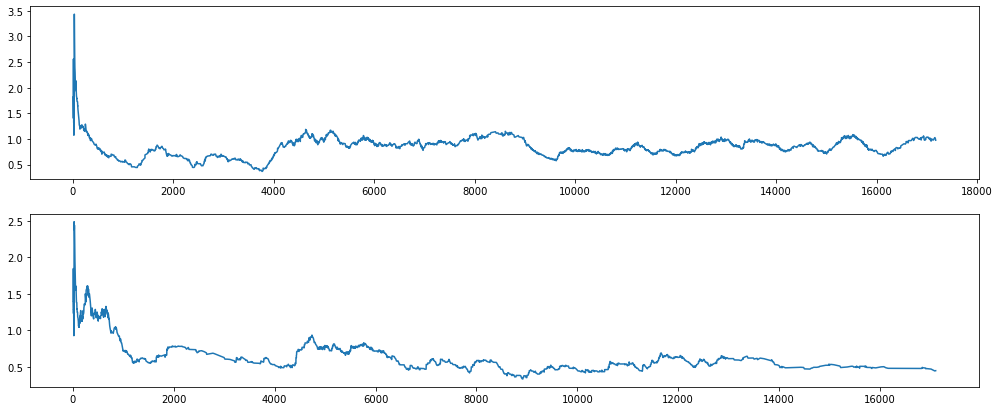

In [19]:
fig = plt.figure()
locator = matplotlib.ticker.MaxNLocator()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'].rolling(50).std()/
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '01']['Interval'].rolling(50).mean())
ax1.xaxis.set_major_locator(locator)
ax2.plot(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'].rolling(50).std()/
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == '02']['Interval'].rolling(50).mean())
ax2.xaxis.set_major_locator(locator)

Построение графика изменения значения временного инварианта от времени для не отфильтрованного по выбросам объекта DataFrame. 

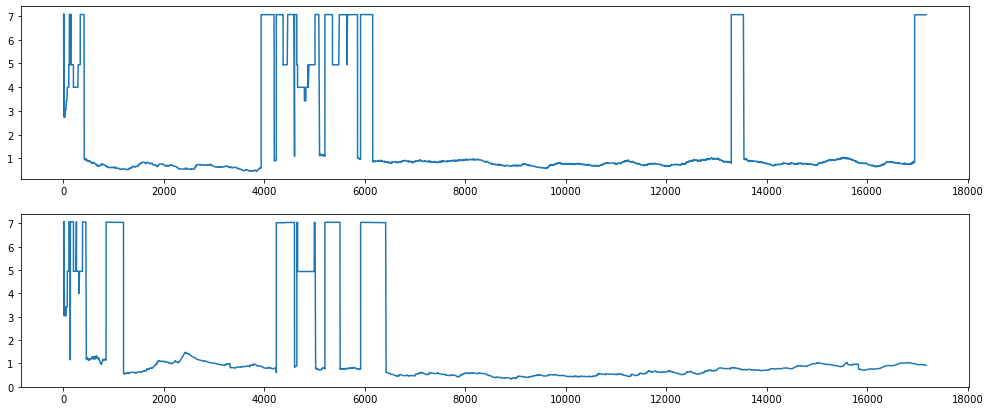

In [20]:
fig = plt.figure()
locator = matplotlib.ticker.MaxNLocator()
fig.set_size_inches(17, 7)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(frame.loc[frame['Number of channel'] == '01']['Time relative'], 
           frame.loc[frame['Number of channel'] == '01']['Interval'].rolling(50).std()/
           frame.loc[frame['Number of channel'] == '01']['Interval'].rolling(50).mean())
ax1.xaxis.set_major_locator(locator)
ax2.plot(frame.loc[frame['Number of channel'] == '02']['Time relative'], 
           frame.loc[frame['Number of channel'] == '02']['Interval'].rolling(50).std()/
           frame.loc[frame['Number of channel'] == '02']['Interval'].rolling(50).mean())
ax2.xaxis.set_major_locator(locator)

Кластеризацию сигналов акустической эмиссии осуществляется с использованием алгоритма кластеризации DBSCAN, алгоритма кластеризации k-средних, алгоритма агломеративной кластеризации. В качества метода предварительной обработки используется StandardScaler, применение которого нормирует данные, обеспечивая среднее значение 0 и дисперсию 1. В качестве метрики кластеризации используется силуэтная мера silhouette_score.

In [21]:
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import silhouette_score
from sklearn.cluster import MeanShift

Алгоритм DBSCAN позволяет выявить плотные области в простанстве признаков. 
Алгоритм DBSCAN имеет два параметра: min_samples и eps. Если по крайней мере min_samples точек находятся в радиусе 
окрестности eps рассматриваемой точки, то эта точка классифицируется как ядровая. Ядровые точки, расстояния между 
которыми не превышают радиус окрестности eps, помещаются алгоритмом DBSCAN в один и тот же кластер.
Применение алгоритма кластеризации DBSCAN с параметрами eps=1.5, min_samples = 2.
Для каждого канала посторены графики зависимости амплитуды сигналов акустической эмиссии от времени для каждого 
выделенного алгоритмом кластера.

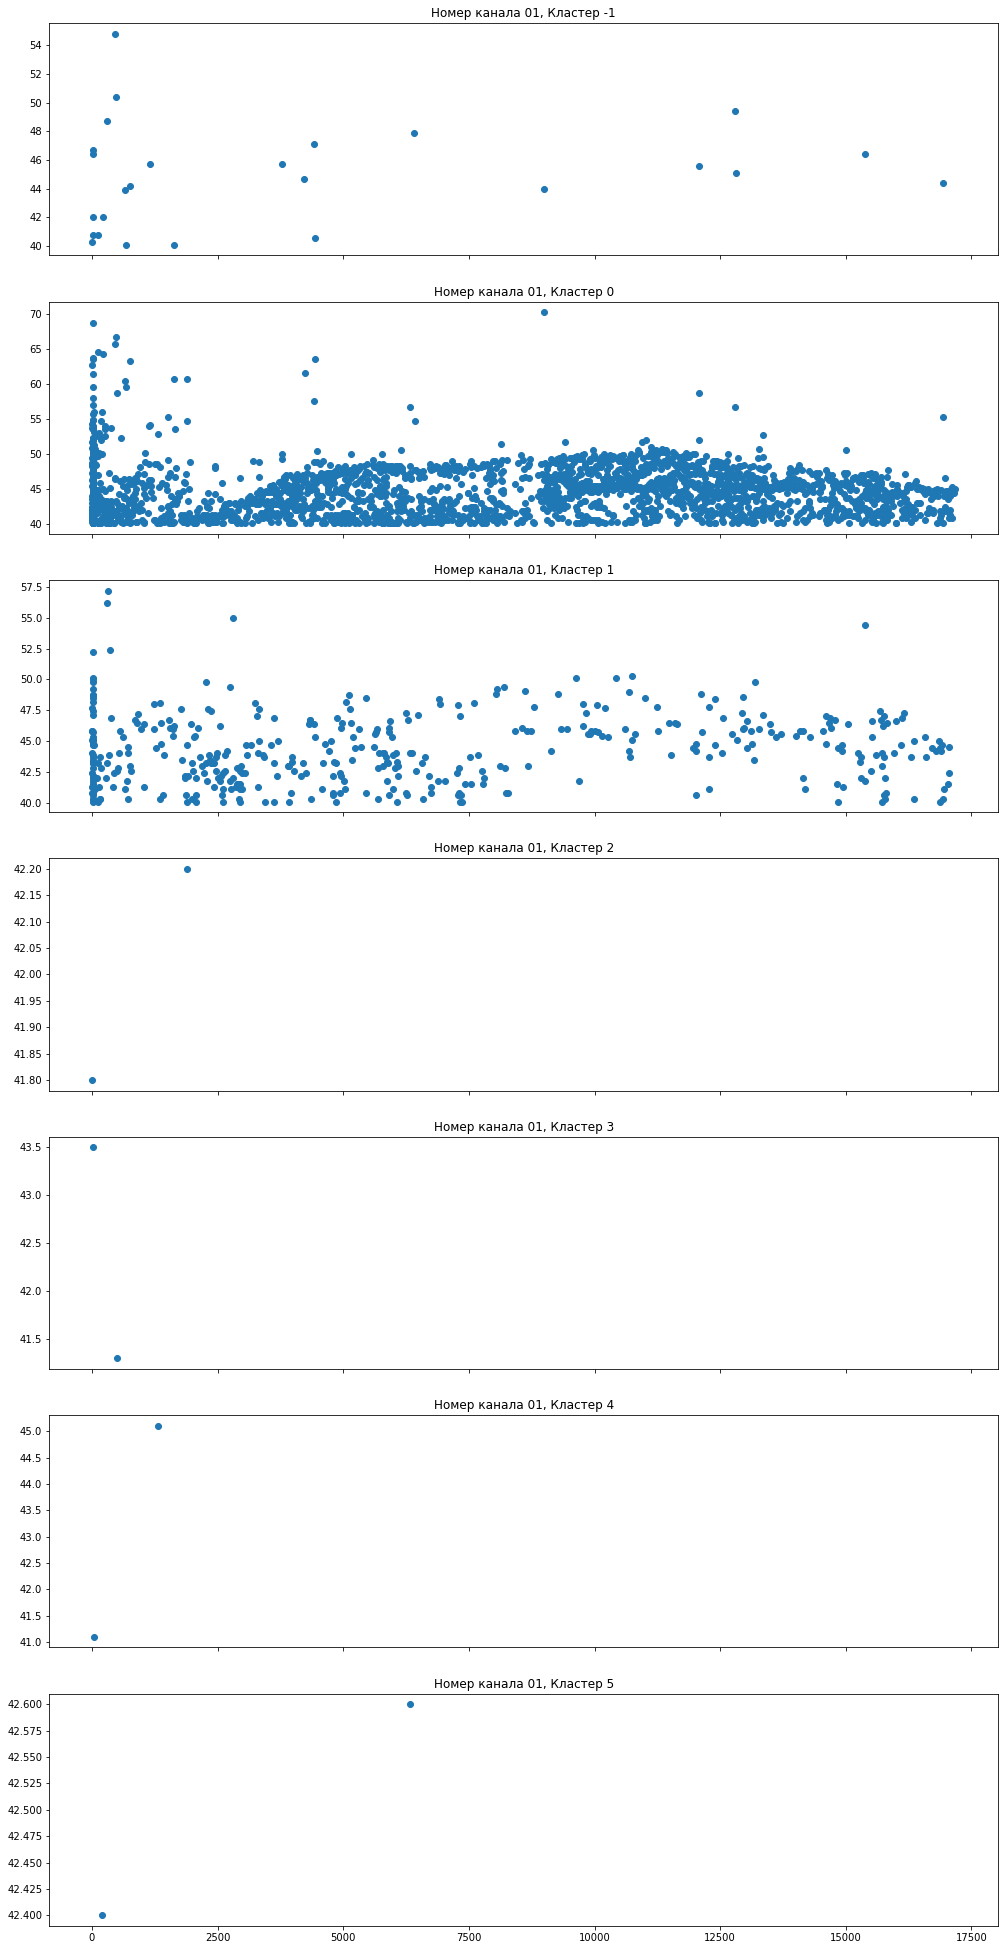

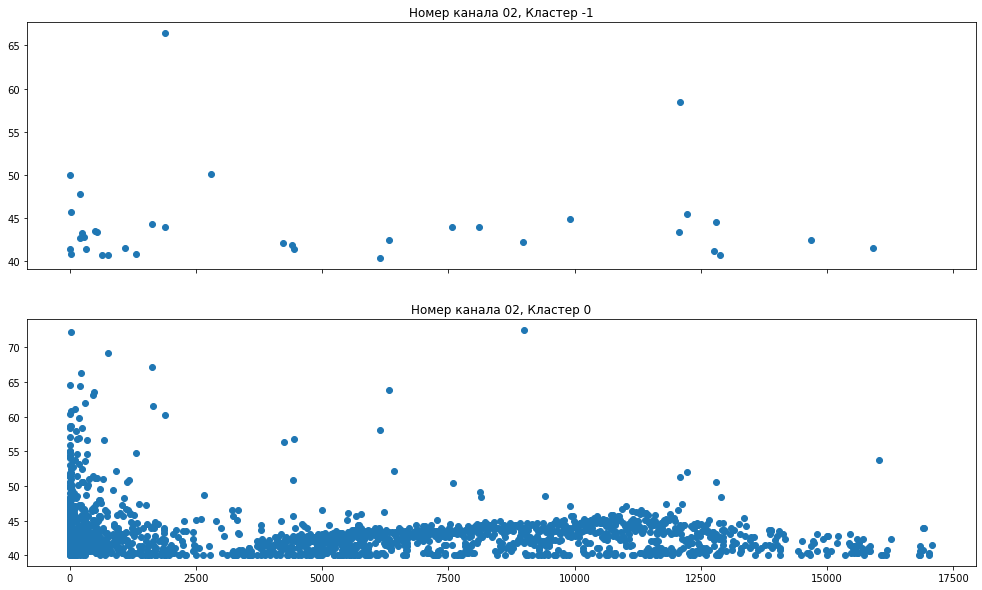

In [22]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    clustering = DBSCAN(eps=1.5, min_samples=2).fit(X_scaled)
    score.append(silhouette_score(X_scaled, clustering.labels_))
    number = list(range(len(np.unique(clustering.labels_))))
    array_clustering.append(clustering.labels_)
    fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
    list_labels = list(np.unique(clustering.labels_))
    for i, labels in zip(number, list_labels):
        locator = matplotlib.ticker.MultipleLocator(base=500)
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

В качестве оценочного показателя кластеризации используется силуэтный коэффициент. Силуэтный коэффициент характеризует расстояние между наблюдениями внутри кластера и расстояние между кластерами. Силуэтный коэффициент $s_i=\frac{b_i-a_i}{max(a_i, b_i)}$, где $a_i$ - среднее расстояние между i и всеми наблюдениями одного класса, $b_i$ - среднее расстояние между i и всеми наблюдениями из ближайшего кластера другого класса. Значение $s_i$ является средним силуэтным коэффициентом для всех наблюдений. Силуэтные коэффициенты варьируются от -1 до 1, причем 1 указывает на плотные, хорошо разделенные кластеры. Расчет силуэтного коэффициента для каждого канала для алгоритма DBSCAN с параметрами eps=1.5, min_samples = 2

In [23]:
print(score[0], score[1])

0.24116163641841154 0.6689126476830112


Постороение графика изменения значения временного инварианта от времени для сформированных кластеров, содержащих более 50 сигналов акустической эмиссии, алгоритм DBSCAN с параметрами eps=1.5, min_samples = 2 

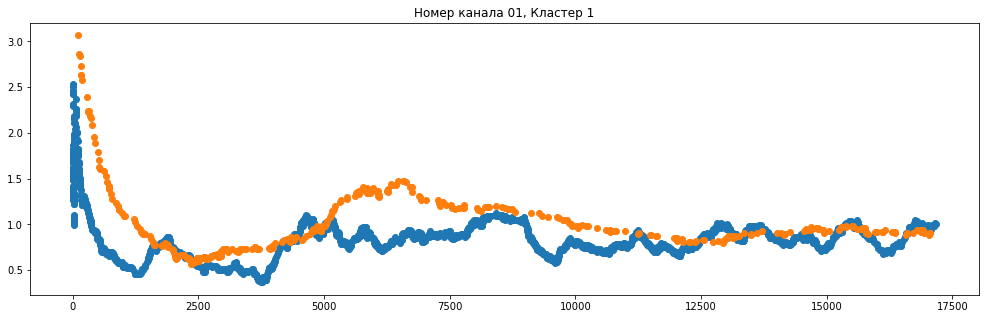

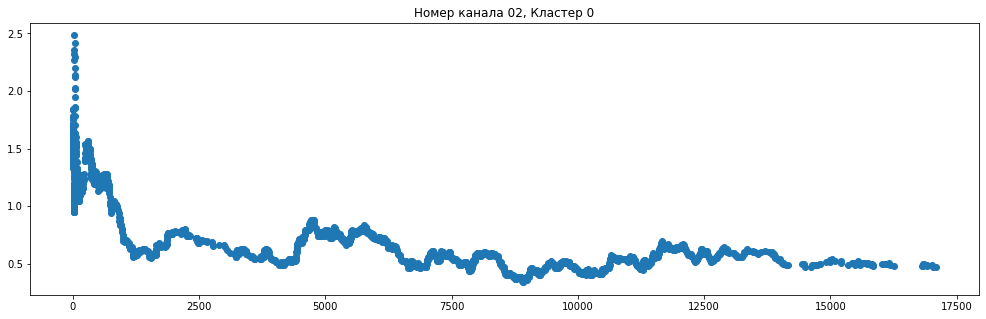

In [24]:
for number_of_channel, list_labels, cluster in zip(['01', '02'], array_labels, array_clustering):
    fig = plt.figure()
    fig.set_size_inches(17, 5)
    ax = fig.add_subplot(1, 1, 1)
    for labels in list_labels:
        if frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)].shape[0] > 50:
            ax.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Time relative'], 
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).std()/
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).mean())
            ax.set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))

Реализация алгоритма кластеризации DBSCAN с параметрами eps=1.5, min_samples = 5. Для каждого канала посторены графики зависимости амплитуды сигналов акустической эмиссии от времени для каждого выделенного алгоритмом кластера.

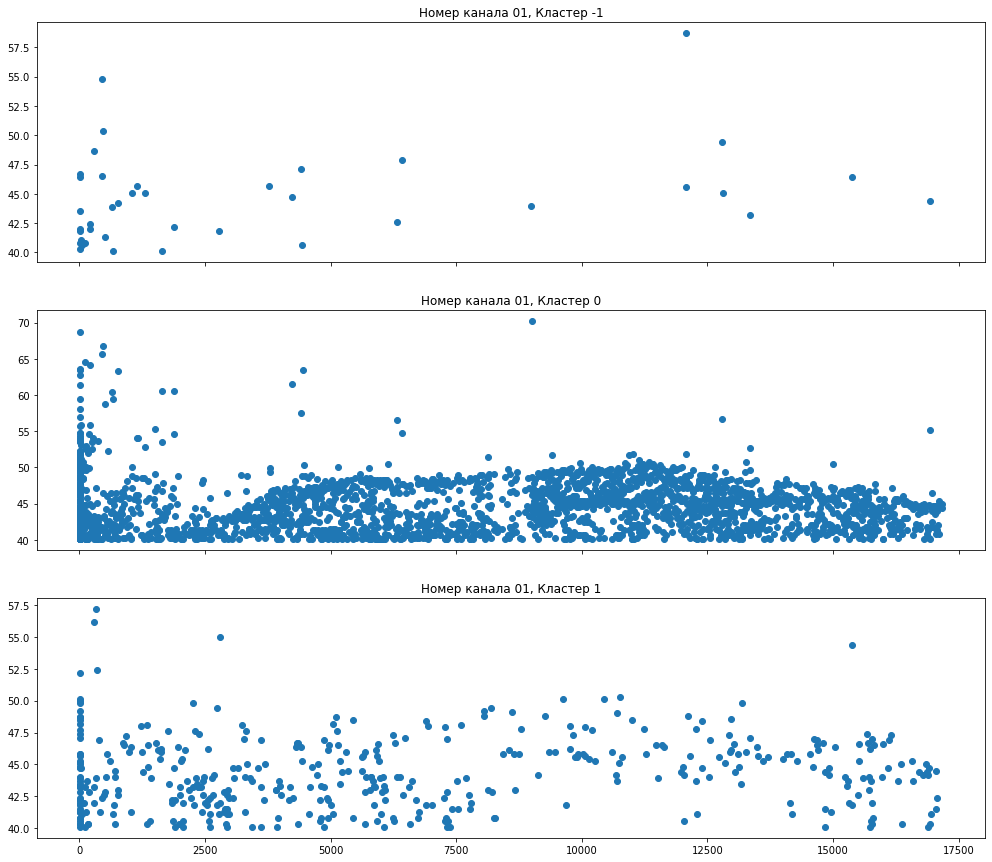

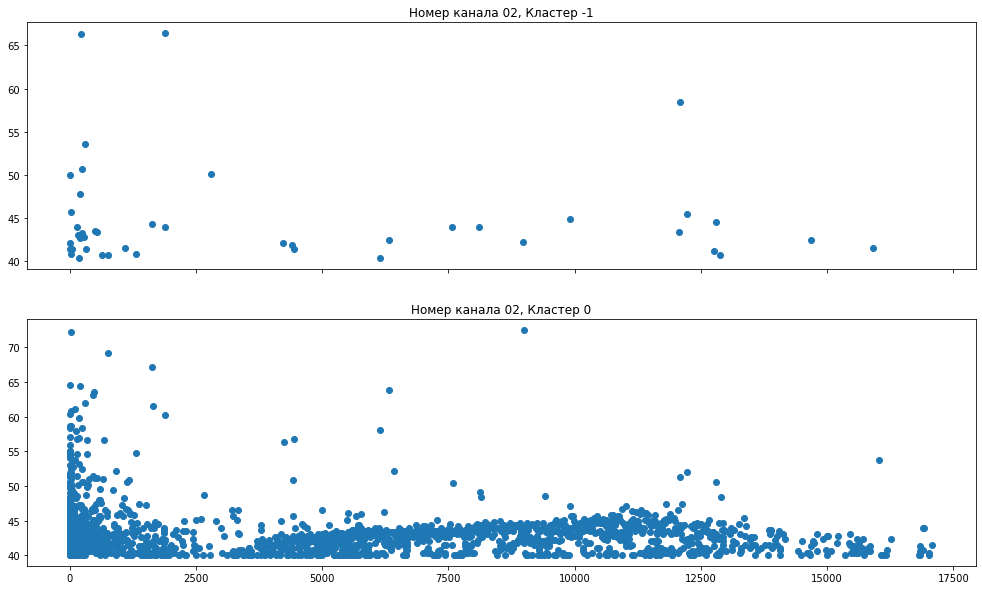

In [25]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    clustering = DBSCAN(eps=1.5, min_samples=5).fit(X_scaled)
    score.append(silhouette_score(X_scaled, clustering.labels_))
    number = list(range(len(np.unique(clustering.labels_))))
    array_clustering.append(clustering.labels_)
    fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
    list_labels = list(np.unique(clustering.labels_))
    for i, labels in zip(number, list_labels):
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

Расчет силуэтного коэффициента для каждого канала для алгоритма DBSCAN с параметрами eps=1.5, min_samples = 5

In [26]:
print(score[0], score[1])

0.26594183923382514 0.6611949875187957


Постороение графика изменения значения временного инварианта от времени для сформированных кластеров, содержащих более 50 сигналов акустической эмиссии, алгоритм DBSCAN с параметрами eps=1.5, min_samples = 5 

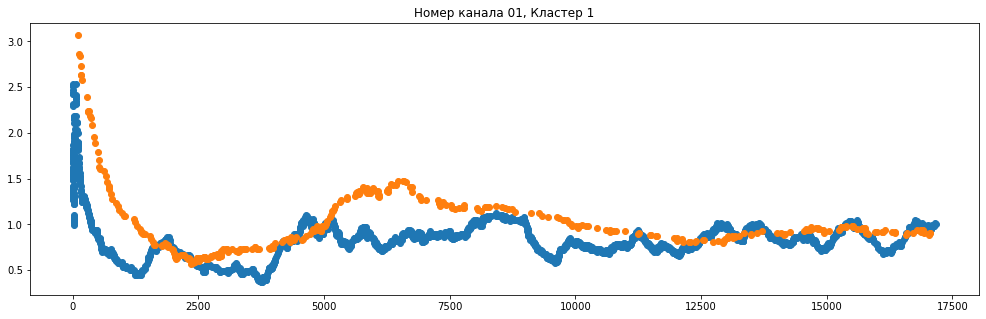

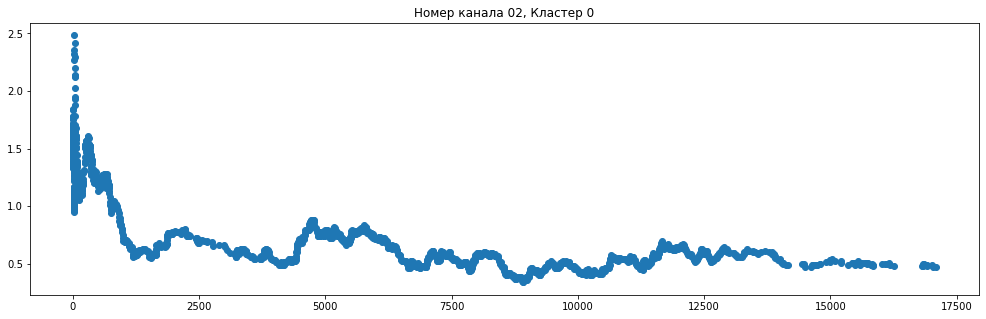

In [27]:
for number_of_channel, list_labels, cluster in zip(['01', '02'], array_labels, array_clustering):
    fig = plt.figure()
    fig.set_size_inches(17, 5)
    ax = fig.add_subplot(1, 1, 1)
    for labels in list_labels:
        if frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)].shape[0] > 50:
            ax.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Time relative'], 
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).std()/
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).mean())
            ax.set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))

Реализация алгоритма сдвига к среднему. Этот алгоритм основан на непараметрическом анализе пространства признаков и использовании дискретных данных для определения местоположения максимумов функции плотности, породившей данные. Для каждого канала посторены графики зависимости амплитуды сигналов акустической эмиссии от времени для каждого выделенного алгоритмом кластера.

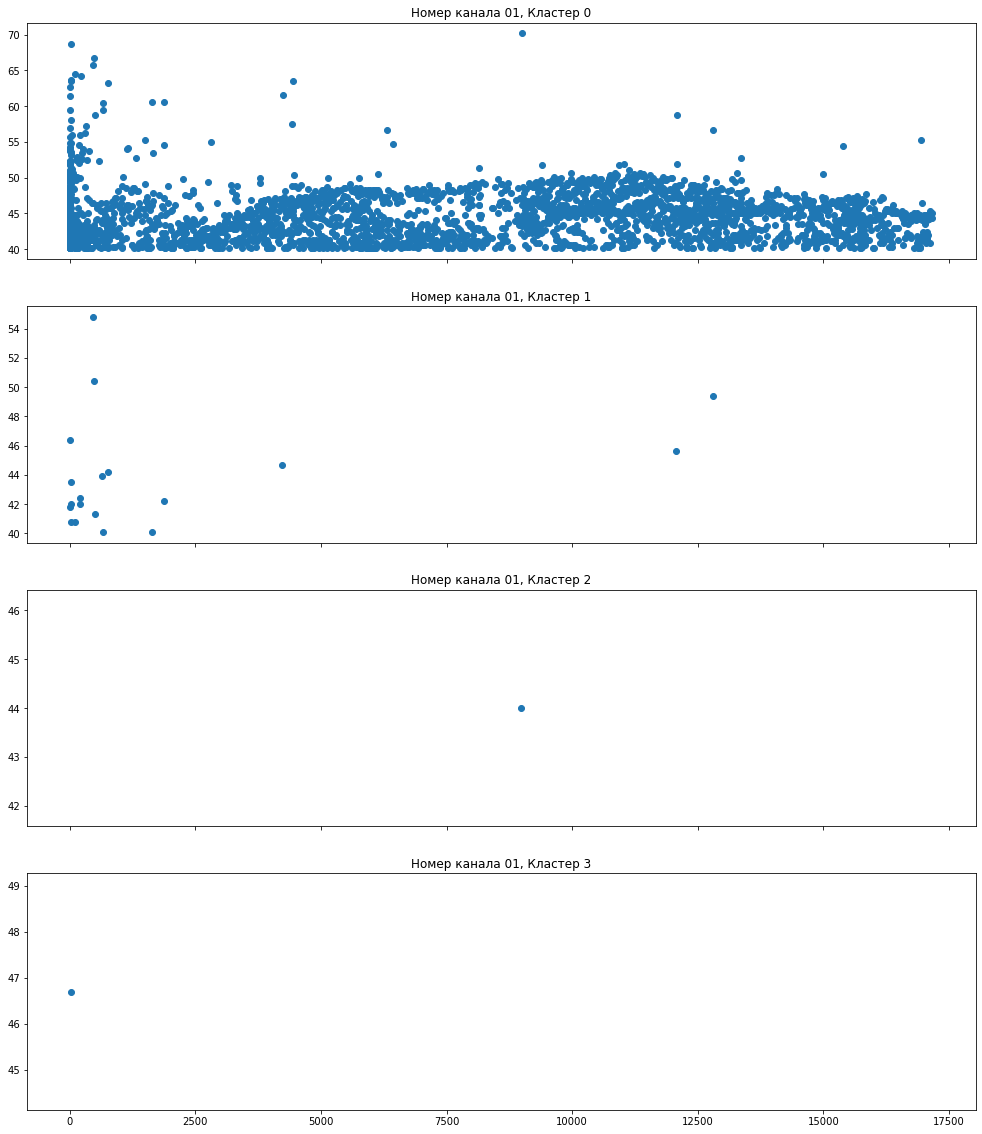

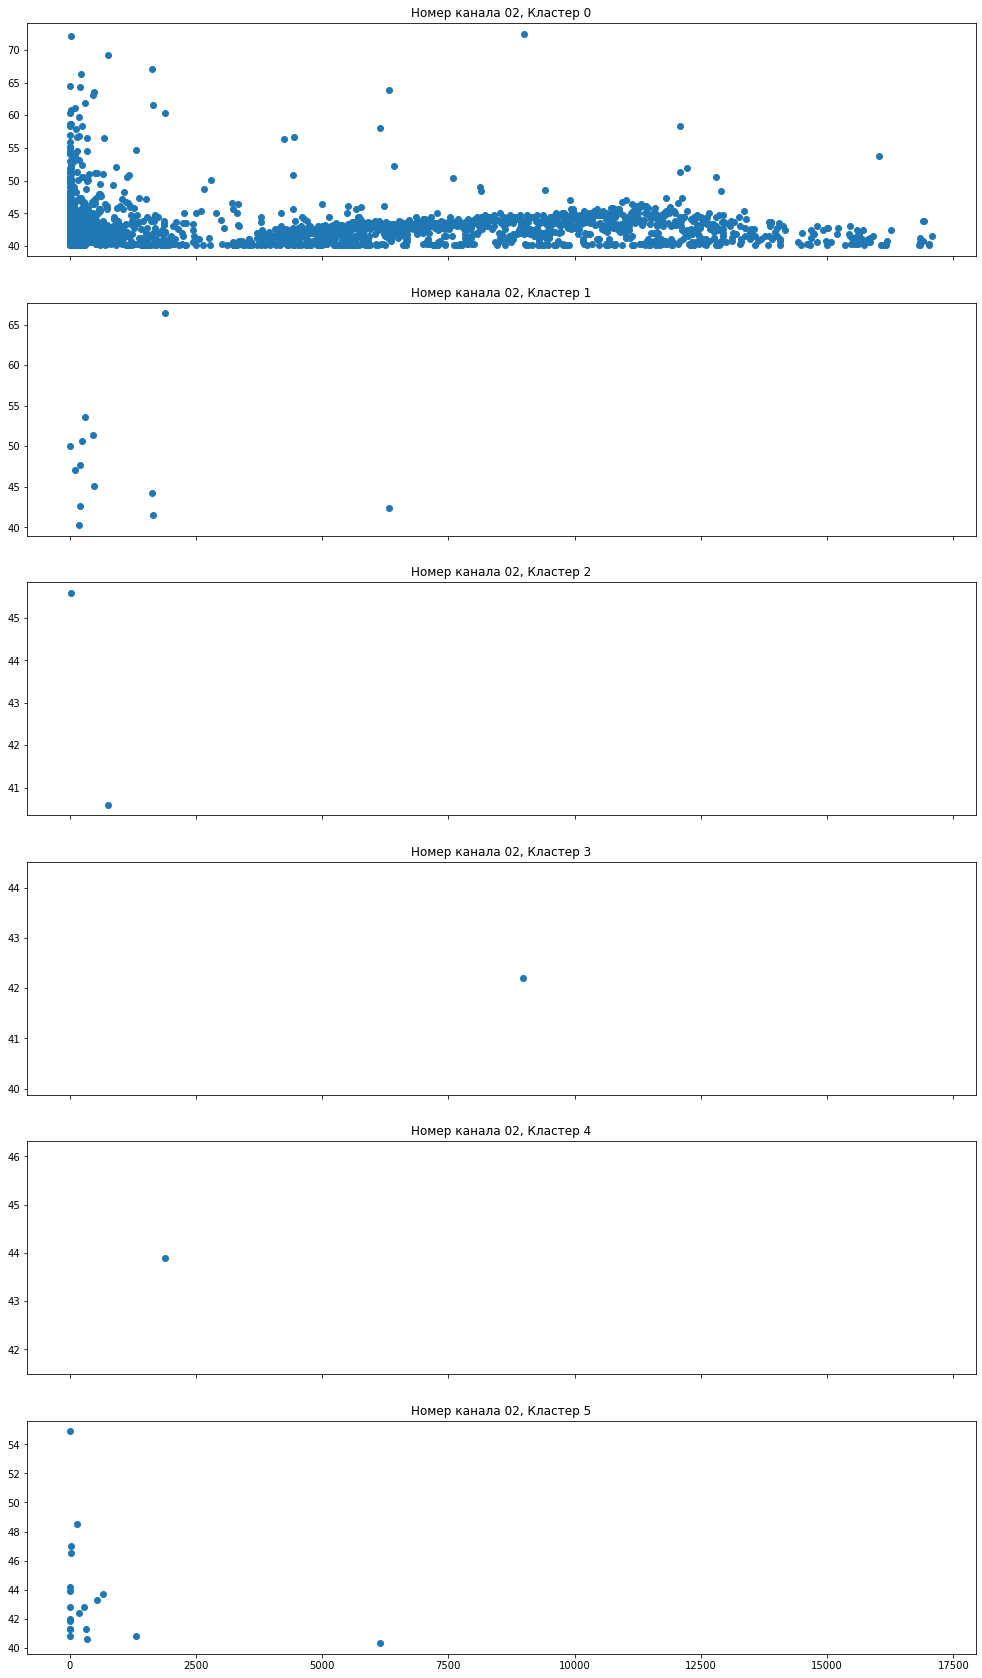

In [28]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    clustering = MeanShift(bandwidth = 4, n_jobs = -1).fit(X_scaled)
    score.append(silhouette_score(X_scaled, clustering.labels_))
    number = list(range(len(np.unique(clustering.labels_))))
    array_clustering.append(clustering.labels_)
    fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
    list_labels = list(np.unique(clustering.labels_))
    for i, labels in zip(number, list_labels):
        locator = matplotlib.ticker.MultipleLocator(base=500)
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(clustering.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

Расчет силуэтного коэффициента для каждого канала для алгоритма сдвига к среднему.

In [29]:
print(score[0], score[1])

0.7032641112791282 0.6177576919853008


Алгорит кластеризации сдвига к среднему классифицировал большинство сигналов в одному кластеру. Изменение параметра ширины полосы bandwidth не повышает информативности метода, изменяя результат классификации в сторону увеличения количества кластеров, в которых содержится небольшое количество сигналов.  Учитывая ограничения, связанные с трудностями применения данного алгоритма на данных большого объема, а также низкую информативность результата кластеризации, применение алгоритма квалстеризации сдвига к среднему нецелесообразно при классификации сигналов акустической эмисии, используя данные, содержащие информацию о форме сигналов акустической эмиссии (см. далее).  

Для реализации алгоритма кластеризации k-средних необходимо задать количество кластеров. Алгоритм в зависимости от расстояния от точки до центра кластера распределяет точки данных по кластерам. Распределние происходит до тех пор, пока расположение центров тяжести кластеров не станет стабильным. Для каждого канала посторены графики зависимости амплитуды сигналов акустической эмиссии от времени для каждого выделенного алгоритмом кластера.

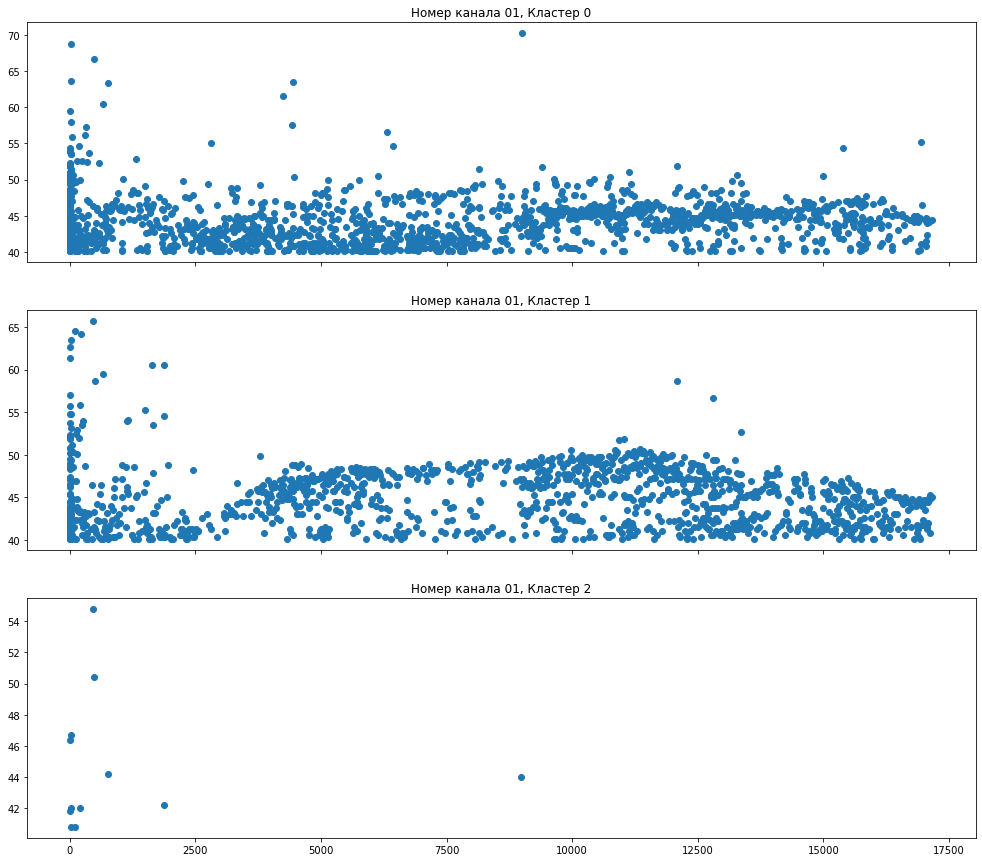

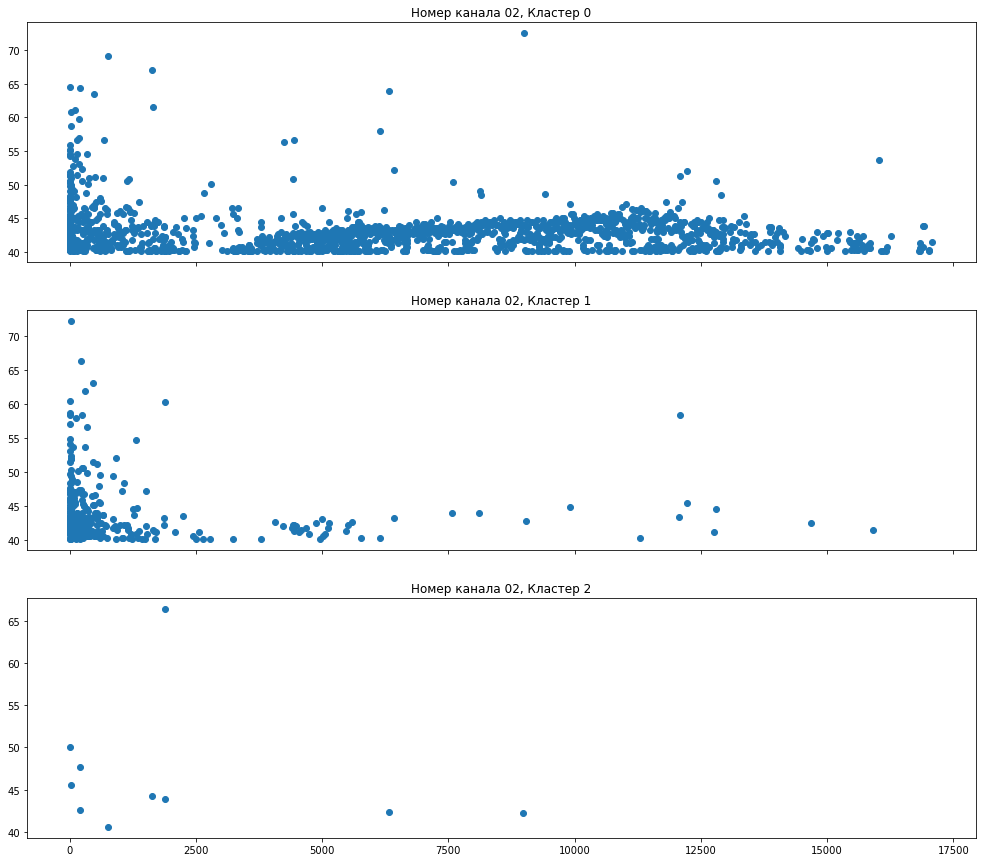

In [30]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(X_scaled)
    score.append(silhouette_score(X_scaled, kmeans.labels_))
    number = list(range(len(np.unique(kmeans.labels_))))
    array_clustering.append(kmeans.labels_)
    fig, axes = plt.subplots(len(np.unique(kmeans.labels_)), 1, figsize=(17, 5*len(np.unique(kmeans.labels_))), sharex=True)
    list_labels = list(np.unique(kmeans.labels_))
    for i, labels in zip(number, list_labels):
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(kmeans.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(kmeans.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

Расчет силуэтного коэффициента для каждого канала для алгоритма k-средних.

In [31]:
print(score[0], score[1])

0.31044684329121436 0.4043835399589411


Постороение графика изменения значения временного инварианта от времени для сформированных кластеров, содержащих более 50 сигналов акустической эмиссии, алгоритм k-средних.

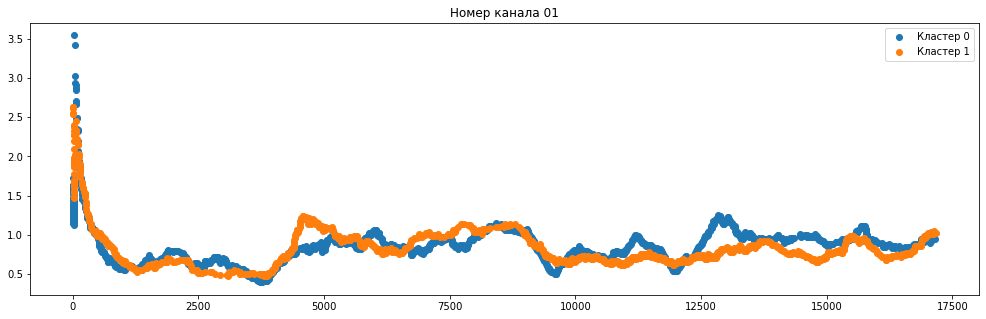

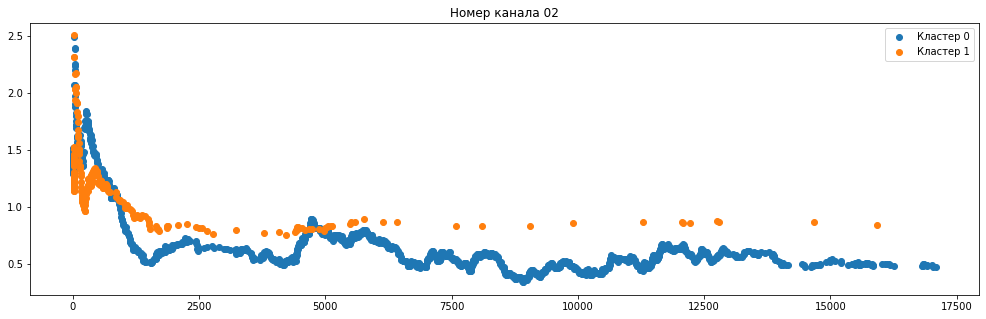

In [32]:
for number_of_channel, list_labels, cluster in zip(['01', '02'], array_labels, array_clustering):
    fig = plt.figure()
    fig.set_size_inches(17, 5)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Номер канала {}".format(number_of_channel))
    for labels in list_labels:
        if frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)].shape[0] > 50:
            ax.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Time relative'], 
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).std()/
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).mean(), label = "Кластер {}".format(labels))
            ax.legend(loc='best')

При реализации алгоритма агломеративной кластеризации происходит объединение сходных между собой кластеров до тех пор, пока не будет сформировано заданное количество кластеров.В качестве критерия схожести кластеров при объединении используется метод ward. Метод ward выбирает и объединяет два кластера так, чтобы прирост дисперсии внутри кластеров был минимальным.

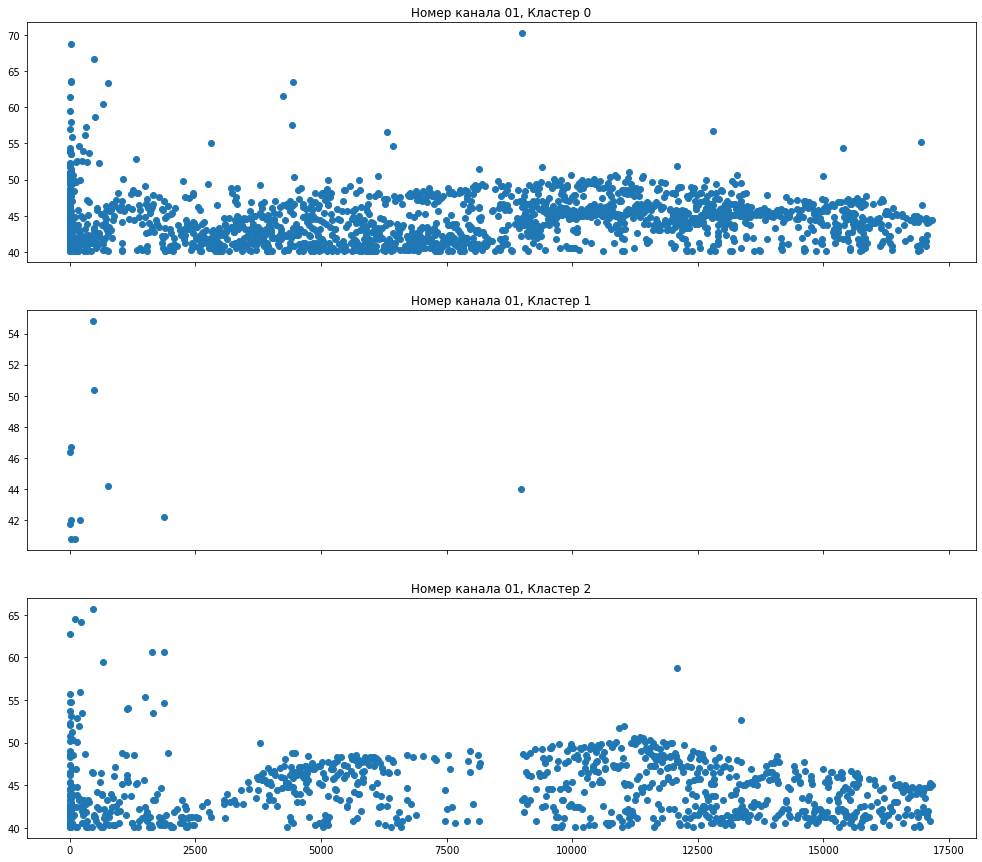

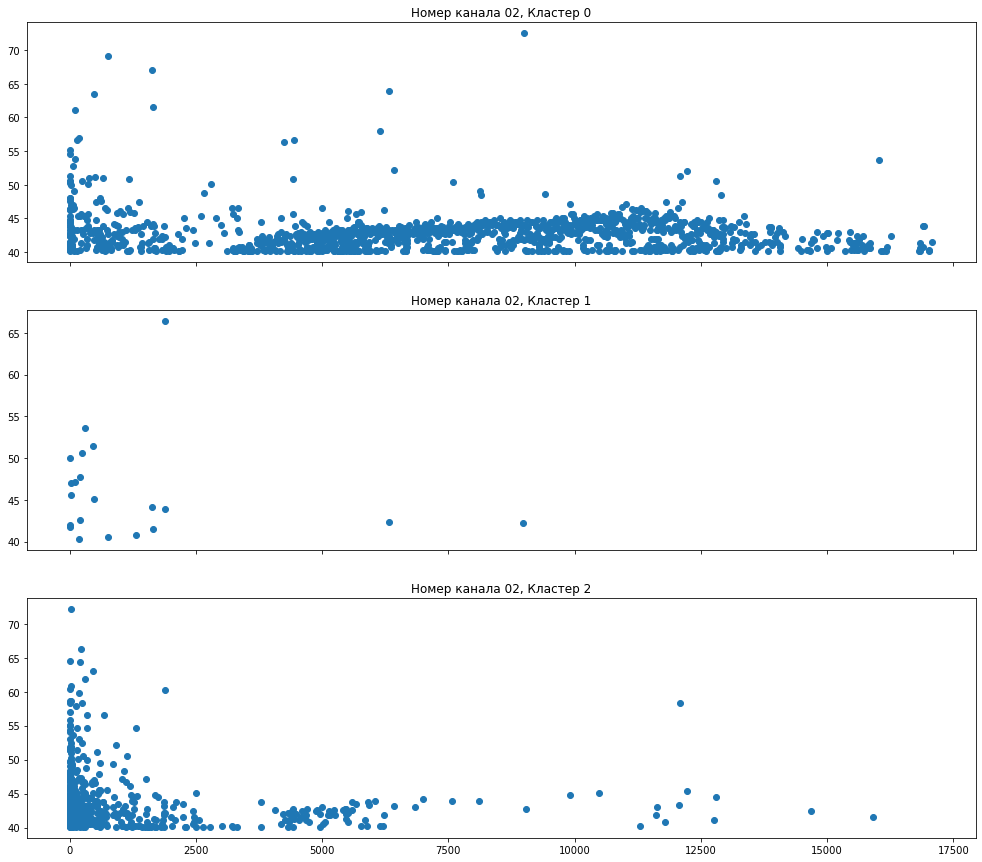

In [33]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    agg = AgglomerativeClustering(n_clusters=3)
    agg.fit(X_scaled)
    score.append(silhouette_score(X_scaled, agg.labels_))
    number = list(range(len(np.unique(agg.labels_))))
    array_clustering.append(agg.labels_)
    fig, axes = plt.subplots(len(np.unique(agg.labels_)), 1, figsize=(17, 5*len(np.unique(agg.labels_))), sharex=True)
    list_labels = list(np.unique(agg.labels_))
    for i, labels in zip(number, list_labels):
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(agg.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(agg.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

Расчет силуэтного коэффициента для каждого канала для алгоритма агломеративной кластеризации, критерии схожести кластеров при объединении ward (по умолчанию).

In [34]:
print(score[0], score[1])

0.2835755806332385 0.29873399774206605


Постороение графика изменения значения временного инварианта от времени для сформированных кластеров, содержащих более 50 сигналов акустической эмиссии, алгоритм агломеративной кластеризации, критерии схожести кластеров при объединении ward (по умолчанию).

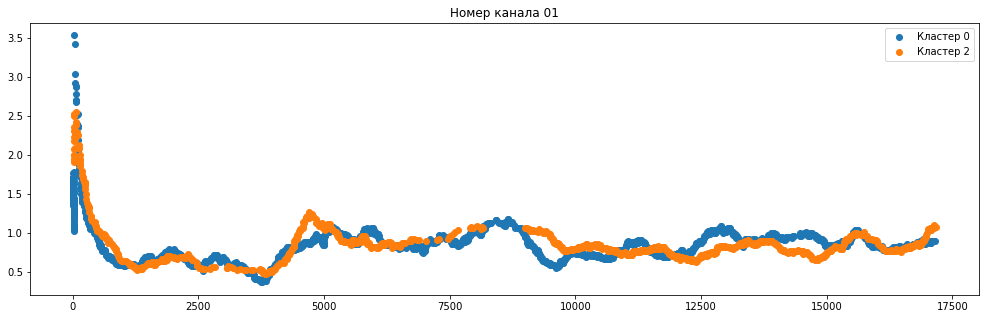

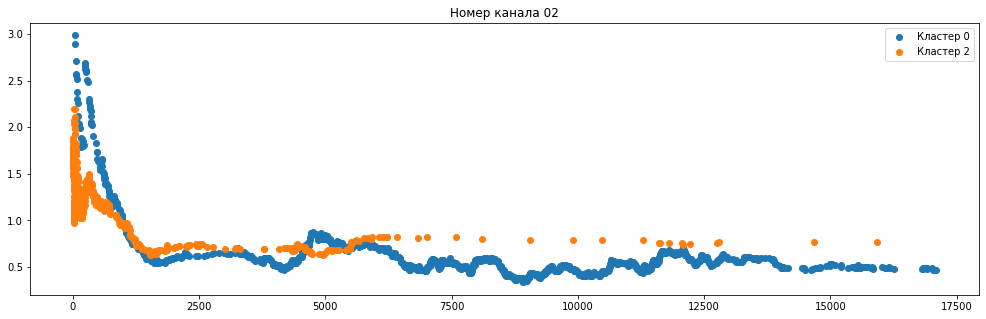

In [35]:
for number_of_channel, list_labels, cluster in zip(['01', '02'], array_labels, array_clustering):
    fig = plt.figure()
    fig.set_size_inches(17, 5)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Номер канала {}".format(number_of_channel))
    for labels in list_labels:
        if frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)].shape[0] > 50:
            ax.scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Time relative'], 
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).std()/
               frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(cluster == labels)]['Interval'].rolling(50).mean(), label = "Кластер {}".format(labels))
            ax.legend(loc='best')

Постороение графика изменения значения временного инварианта от времени для сформированных кластеров, содержащих более 50 сигналов акустической эмиссии, алгоритм агломеративной кластеризации, критерии схожести кластеров при объединении average.

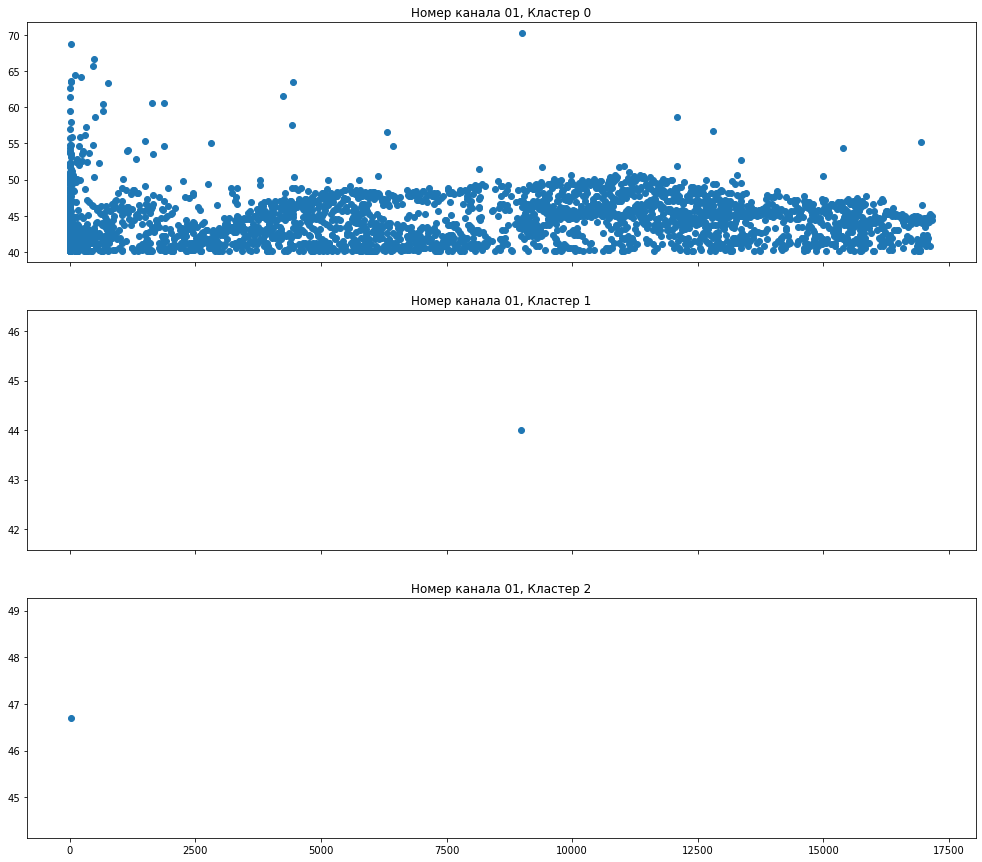

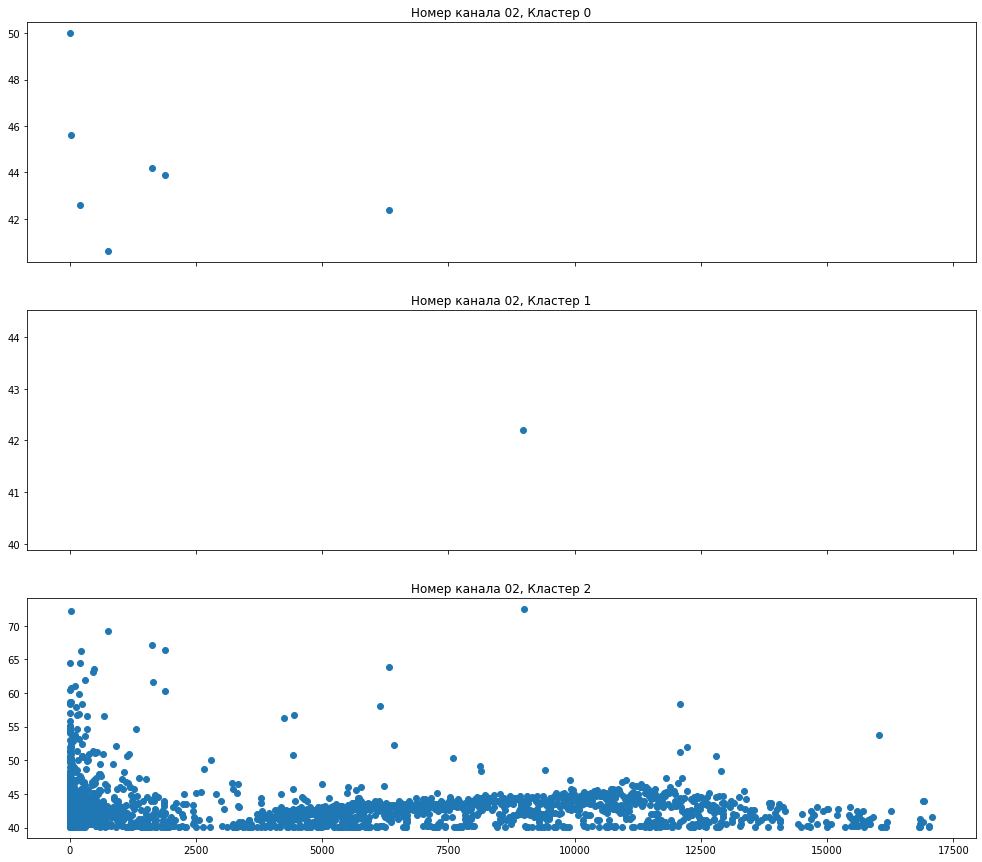

In [36]:
score = []
array_labels = []
array_clustering =[]
for number_of_channel in ['01', '02']:
    X = frame_no_outlier.drop(['Time', 'Amplitude, ADC', 'Amplitude, mkV', 'Amplitude/Counts, mkV'], axis = 1).dropna().loc[frame_no_outlier['Number of channel'] == number_of_channel].values
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    agg = AgglomerativeClustering(n_clusters=3, linkage='average')
    agg.fit(X_scaled)
    score.append(silhouette_score(X_scaled, agg.labels_))
    number = list(range(len(np.unique(agg.labels_))))
    array_clustering.append(agg.labels_)
    fig, axes = plt.subplots(len(np.unique(agg.labels_)), 1, figsize=(17, 5*len(np.unique(agg.labels_))), sharex=True)
    list_labels = list(np.unique(agg.labels_))
    for i, labels in zip(number, list_labels):
        axes[i].scatter(frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(agg.labels_== labels)]['Time relative'], 
           frame_no_outlier.loc[frame_no_outlier['Number of channel'] == number_of_channel].iloc[np.where(agg.labels_== labels)]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))
    array_labels.append(list_labels)

Решение задачи кластеризации сигналов акустической эмиссии с использованием информации о форме сигнала. Открытие, чтение файла, содержащего информацию о форме сигнала акустической эмиссии.

In [37]:
f = open(r'C:\Users\homepc\Documents\Pyton\aem14_01_13#02_osc.txt', 'r', encoding="utf-16")
frame_osc = pd.read_table(f, sep ='\s+', names = ['Number of signal', 'Number of point', 'Time', 'Amplitude'])
f.close()

Преобразование данных в столбцах 'Time', 'Amplitude' в числовой формат. 

In [38]:
f1 = lambda x: float(x)
for column in ['Time', 'Amplitude']:
    frame_osc[column] = frame_osc[column].apply(f1)

Создание таблицы, содержащей временной шаг оцифровки сигнала акустической эмиссии.

In [39]:
time = frame_osc[frame_osc['Number of signal'] == 1]['Time']

Формирование объекта DataFrame, содержащего информацию о форме сигналов акустической эмиссии. Каждая строка объекта DataFrame содержит значения амплитуды сигнала акустической эмиссии в моменты времени, сдвинутые на шаг оцифровки.

In [40]:
dataset = frame_osc.drop('Time', axis = 1)
dataset = dataset.pivot('Number of signal', 'Number of point')
dataset

Amplitude                                                   \
Number of point       1      2      3      4      5      6      7      8      
Number of signal                                                              
1                   -158.0 -158.0 -159.0 -163.0 -165.0 -162.0 -158.0 -156.0   
2                   -161.0 -162.0 -164.0 -166.0 -166.0 -165.0 -165.0 -165.0   
3                     -1.0    1.0    1.0   -1.0   -2.0    0.0    2.0    2.0   
4                     -6.0   -4.0   -1.0    3.0    6.0    8.0    9.0    7.0   
5                     14.0   15.0   15.0   14.0    7.0   -3.0  -10.0  -12.0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
4819                  17.0   14.0    4.0    0.0    6.0   12.0    7.0   -6.0   
4820                   4.0    7.0    7.0    5.0    4.0    3.0    2.0   -1.0   
4821                   0.0    0.0    0.0    0.0   -2.0   -2.0   -2.0   -1.0   
4822                   1.0    2.0    0.0    0.0    1.0    3.0    2.0    0.0   
4823                   3.0    4.0    6.0    8.0    7.0    4.0    0.0   -3.0   

                                ...                                         \
Number of point    9      10    ...  991   992   993  994  995  996   997    
Number of signal                ...                                          
1                -159.0 -162.0  ...  -2.0  -2.0   0.0  2.0  4.0  4.0   3.0   
2                -164.0 -164.0  ...   1.0   0.0   0.0  0.0  0.0  1.0   2.0   
3                   1.0    1.0  ...   1.0   0.0   0.0  0.0 -1.0 -3.0  -2.0   
4                   5.0    3.0  ...   0.0   2.0   1.0 -2.0 -2.0  0.0   1.0   
5                 -11.0   -9.0  ...   5.0   8.0   9.0  8.0  5.0  1.0  -1.0   
...                 ...    ...  ...   ...   ...   ...  ...  ...  ...   ...   
4819              -13.0   -9.0  ...  14.0  14.0  10.0  4.0 -3.0 -8.0 -10.0   
4820               -2.0   -2.0  ...   3.0   7.0   8.0  3.0 -2.0 -2.0  -2.0   
4821               -1.0    0.0  ...  -3.0  -3.0  -2.0 -1.0 -2.0 -1.0   3.0   
4822                1.0    2.0  ...  -7.0  -5.0  -2.0  1.0  4.0  4.0   3.0   
4823               -6.0   -7.0  ...   7.0   9.0   6.0  0.0 -4.0 -3.0  -2.0   

                                  
Number of point   998  999  1000  
Number of signal                  
1                  2.0  2.0  2.0  
2                  3.0  4.0  6.0  
3                  1.0  2.0  0.0  
4                  2.0  3.0  3.0  
5                 -3.0 -6.0 -7.0  
...                ...  ...  ...  
4819             -10.0 -9.0 -6.0  
4820              -5.0 -9.0 -8.0  
4821               5.0  5.0  1.0  
4822               3.0  4.0  3.0  
4823              -5.0 -7.0 -5.0  

[4823 rows x 1000 columns]

Реализация алгоритма кластеризации DBSCAN с параметрами eps=8, min_samples = 10 для данных, содержащих информацию о форме сигналов акустической эмиссии. 

In [41]:
X = dataset
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
clustering = DBSCAN(eps=8, min_samples=10).fit(X_scaled)

Отображение первых четырех сигналов акустической эмисии, входящих в каждый кластер.

<ipython-input-42-078bd60f8ff9>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 4, figsize=(15, 10))


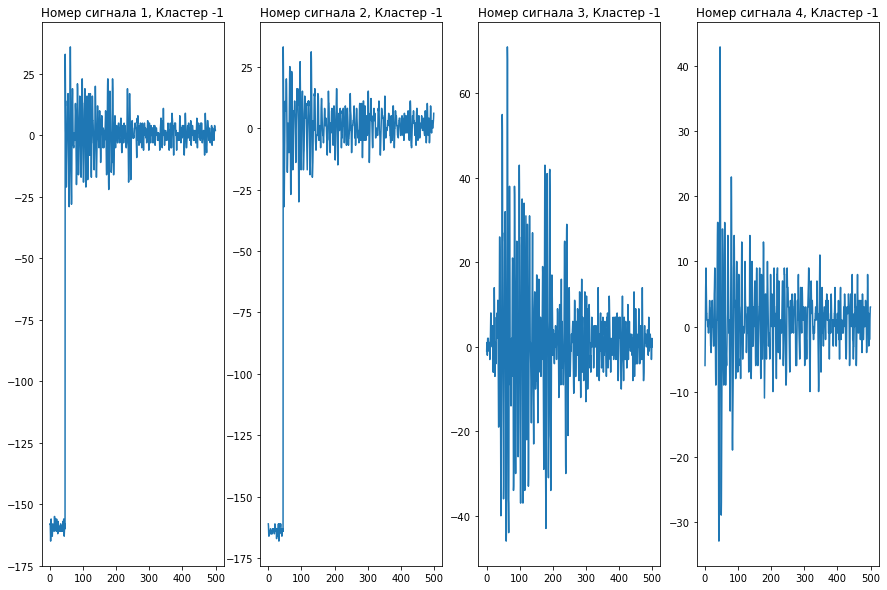

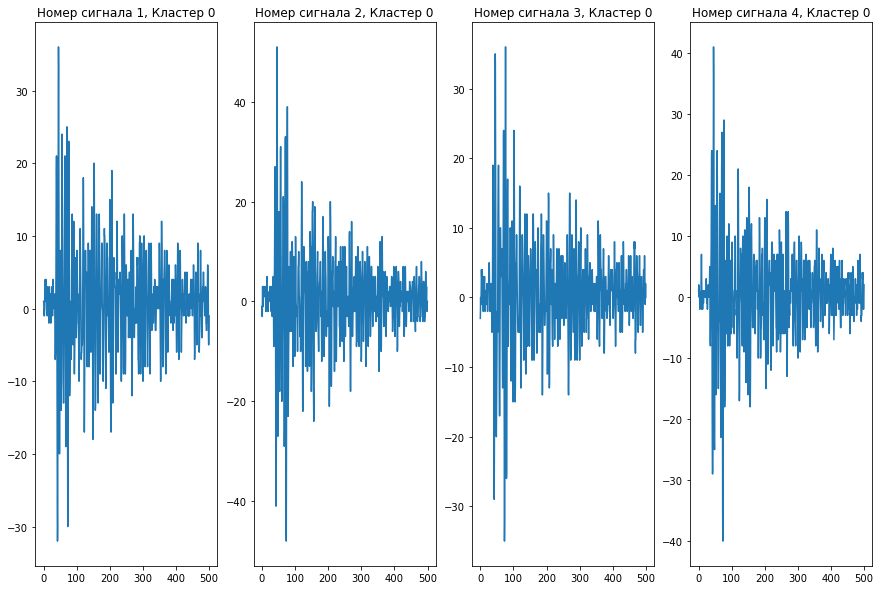

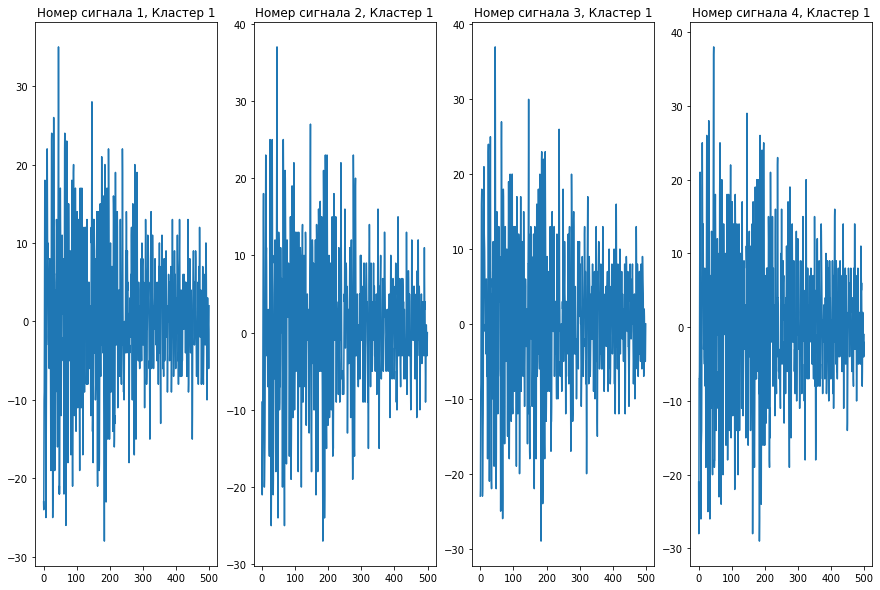

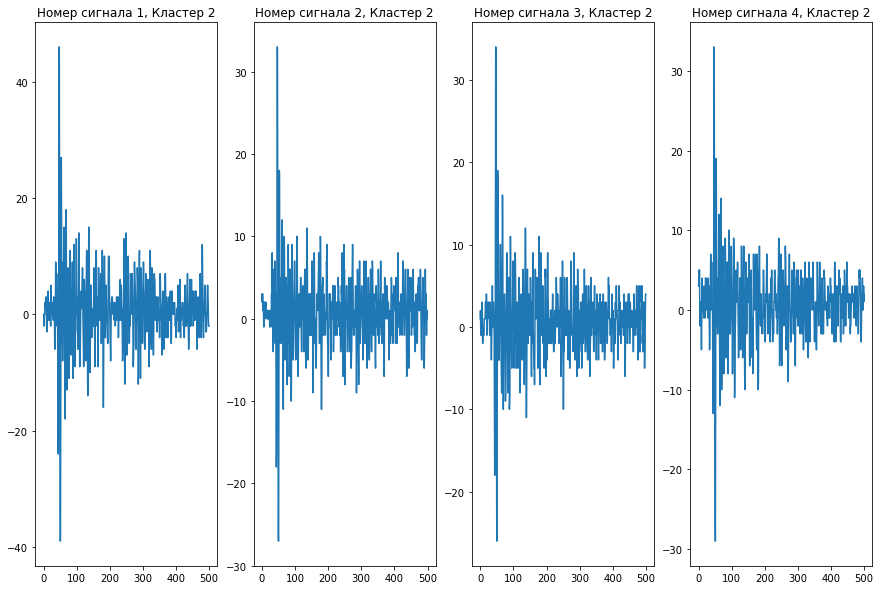

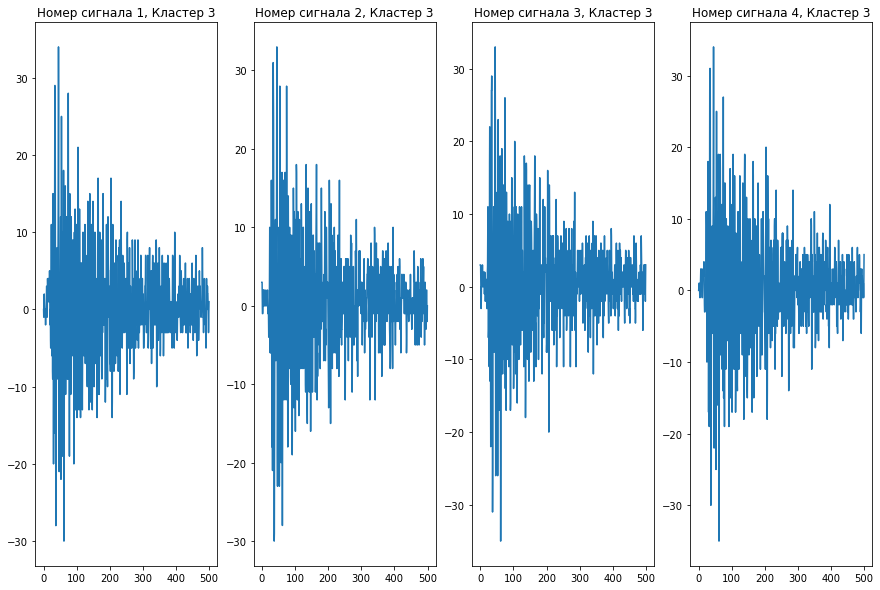

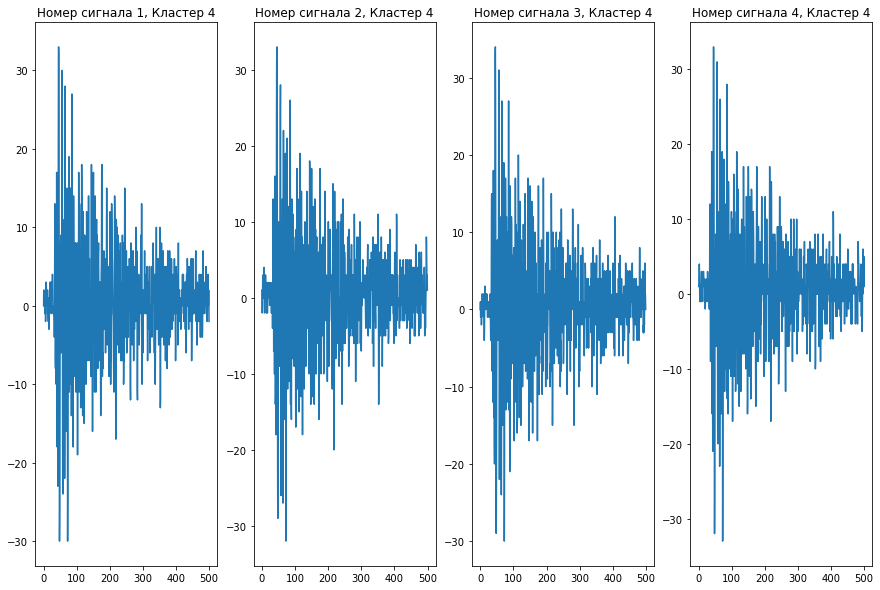

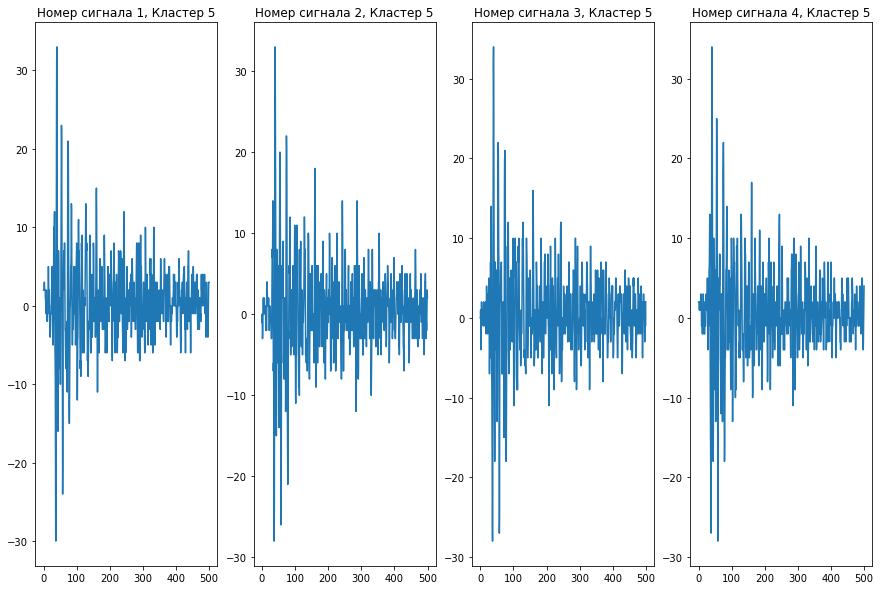

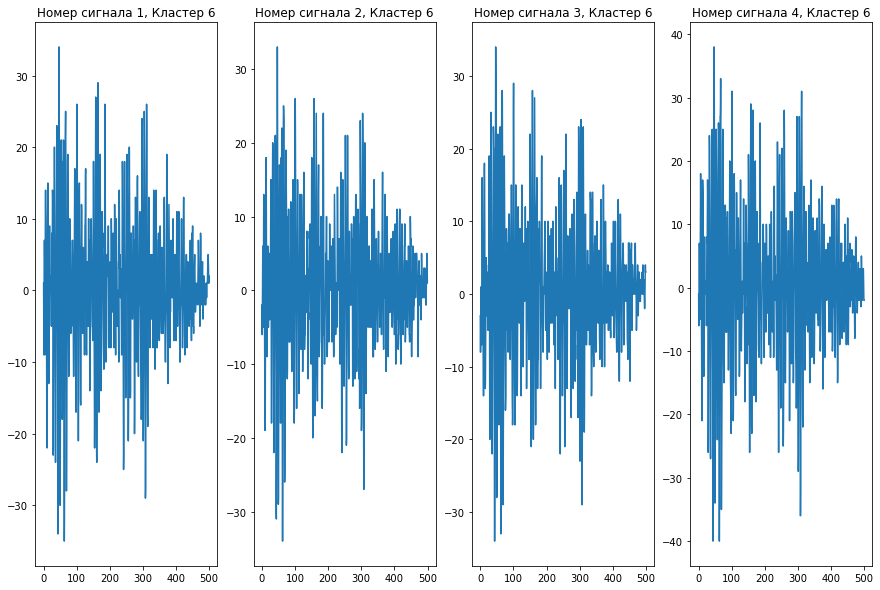

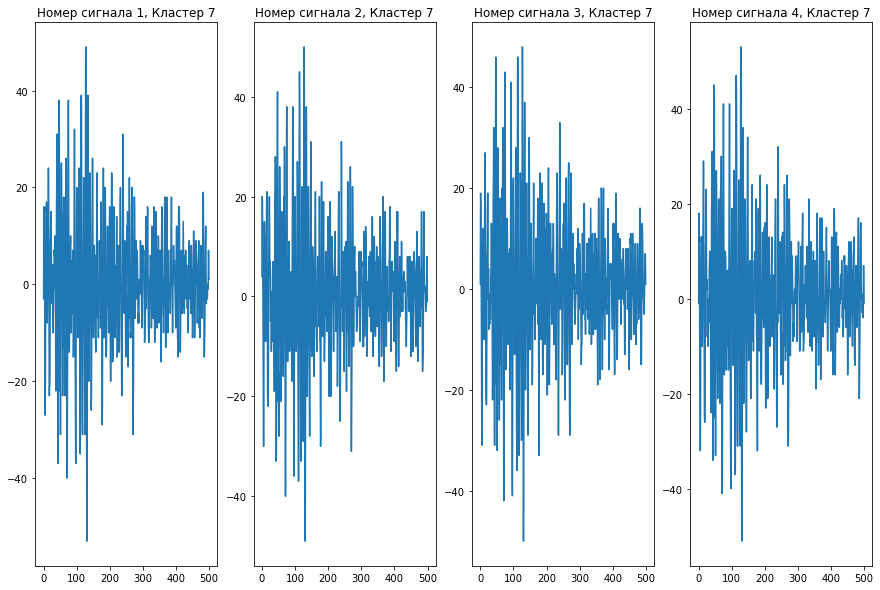

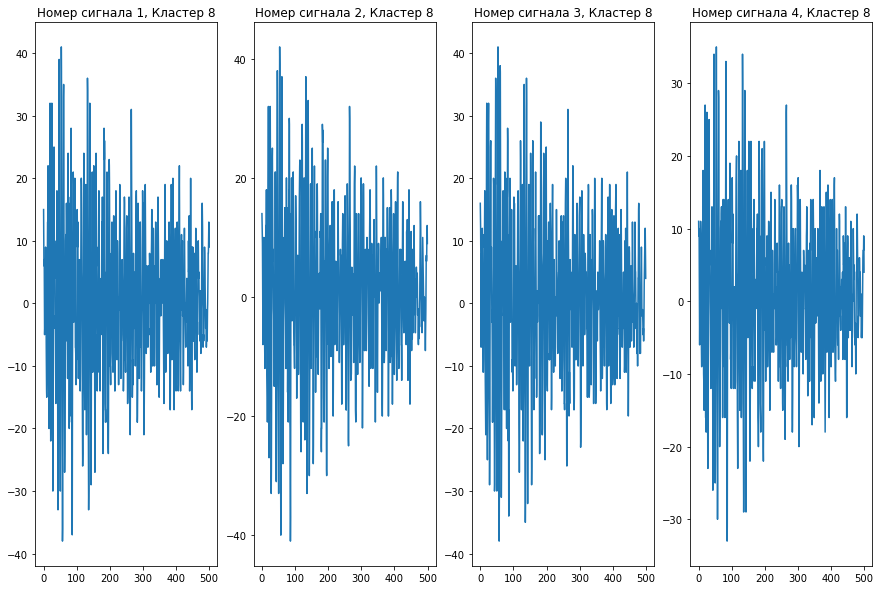

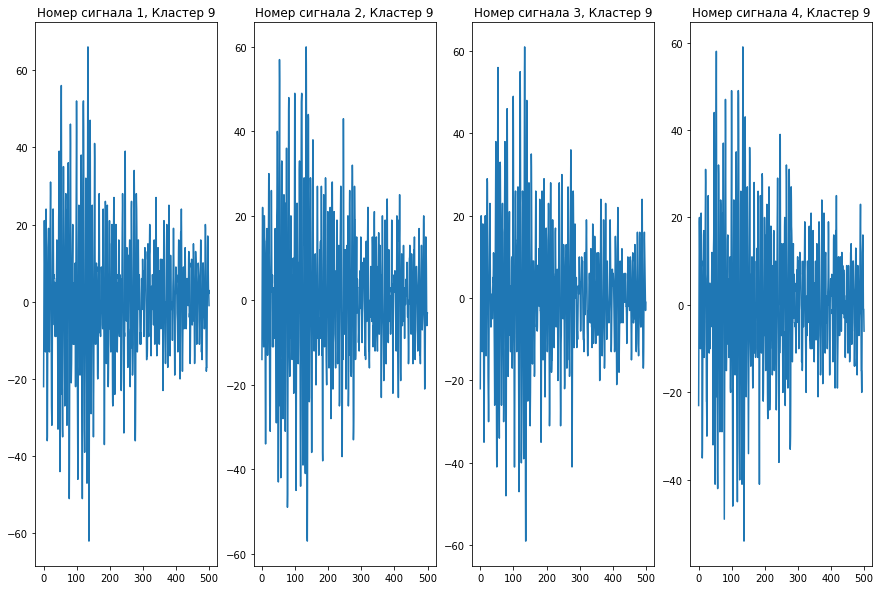

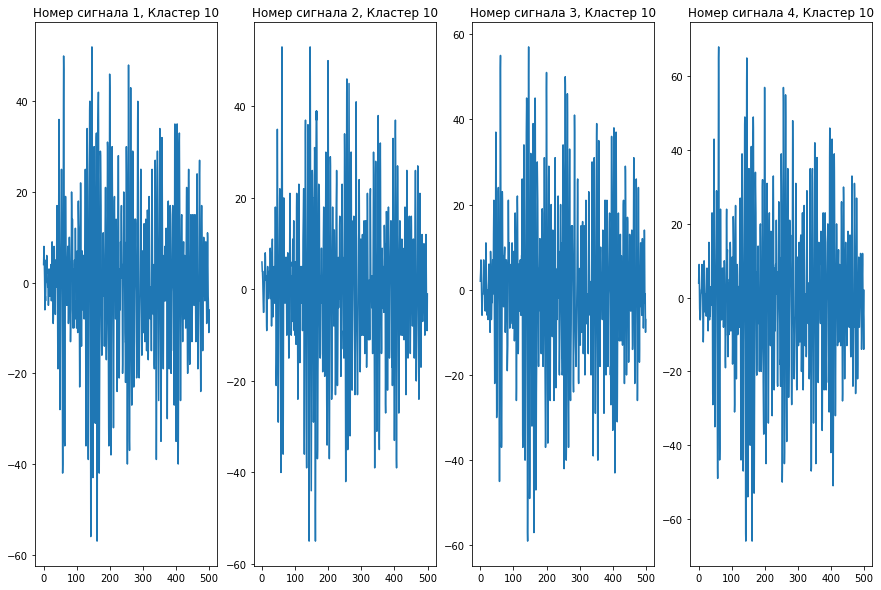

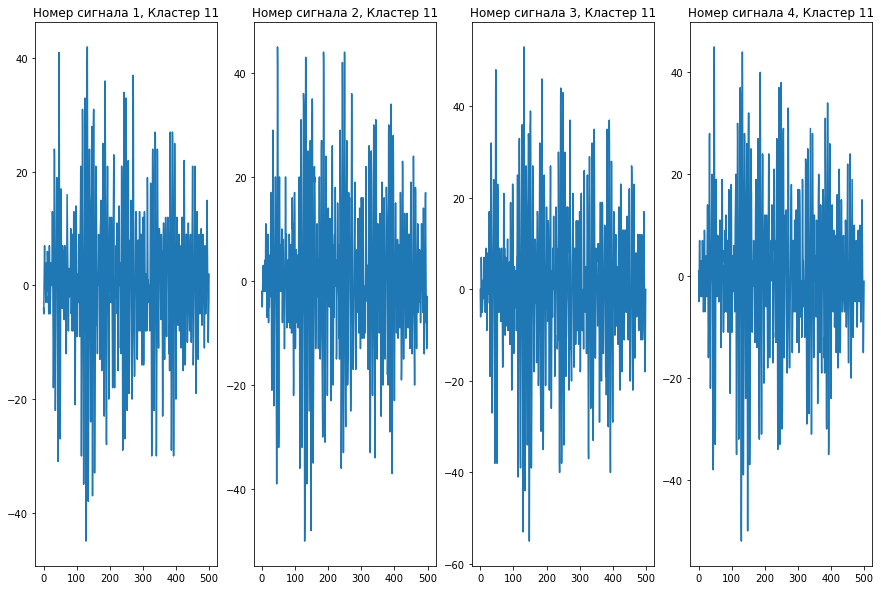

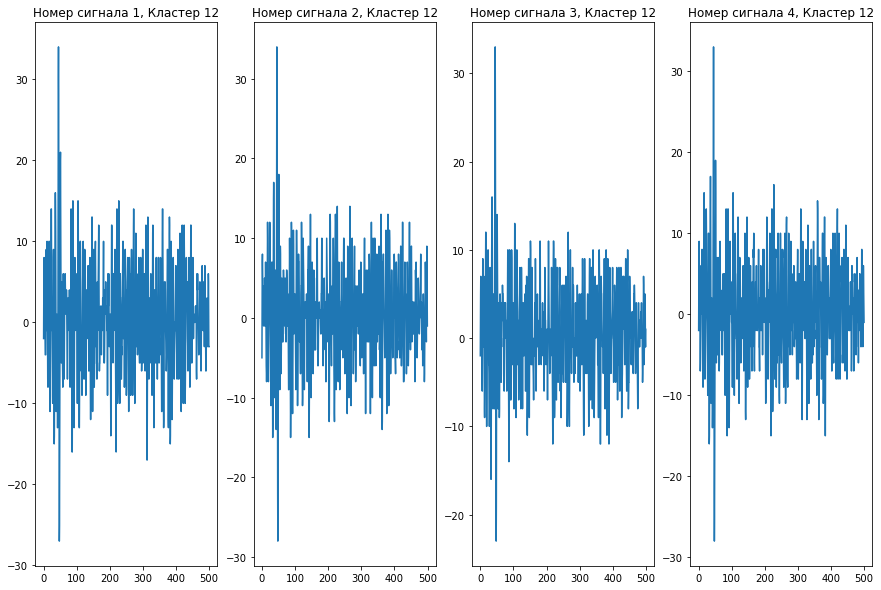

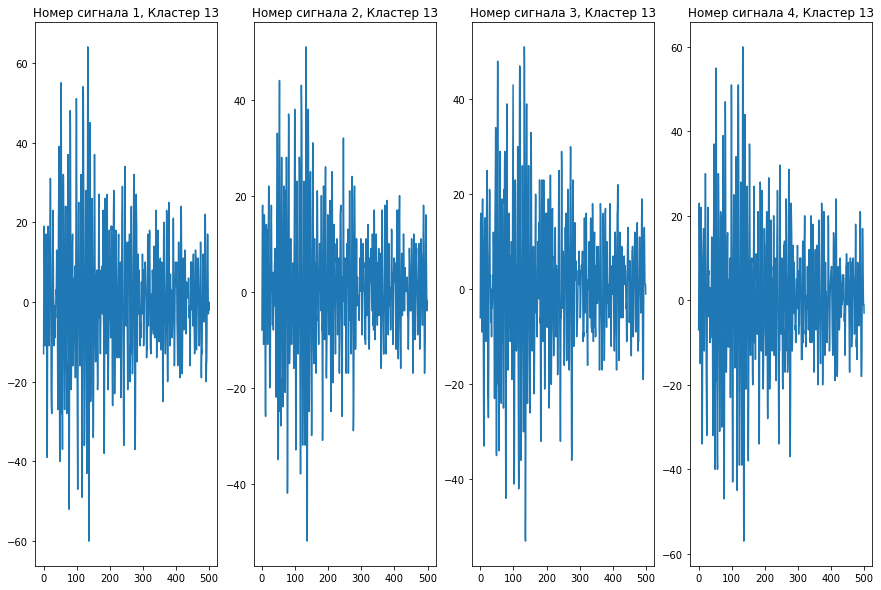

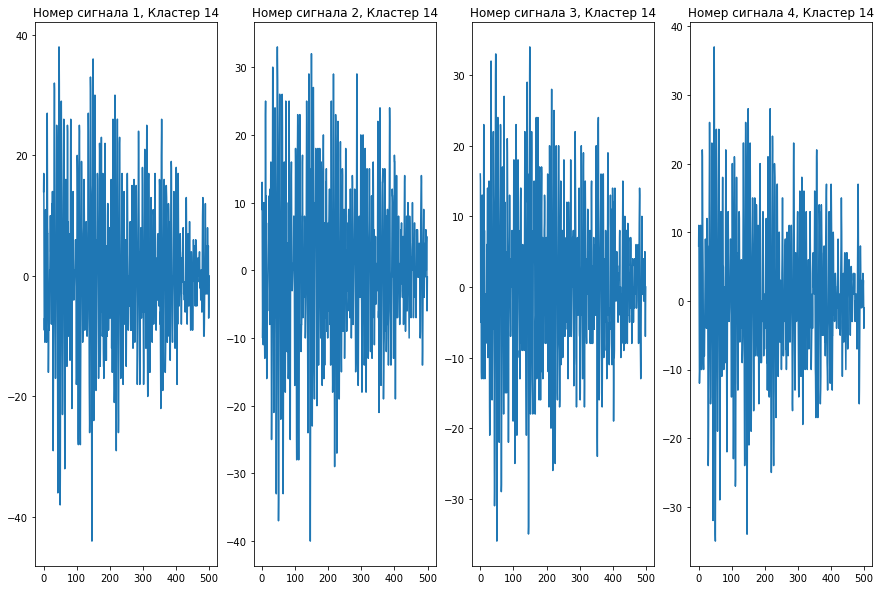

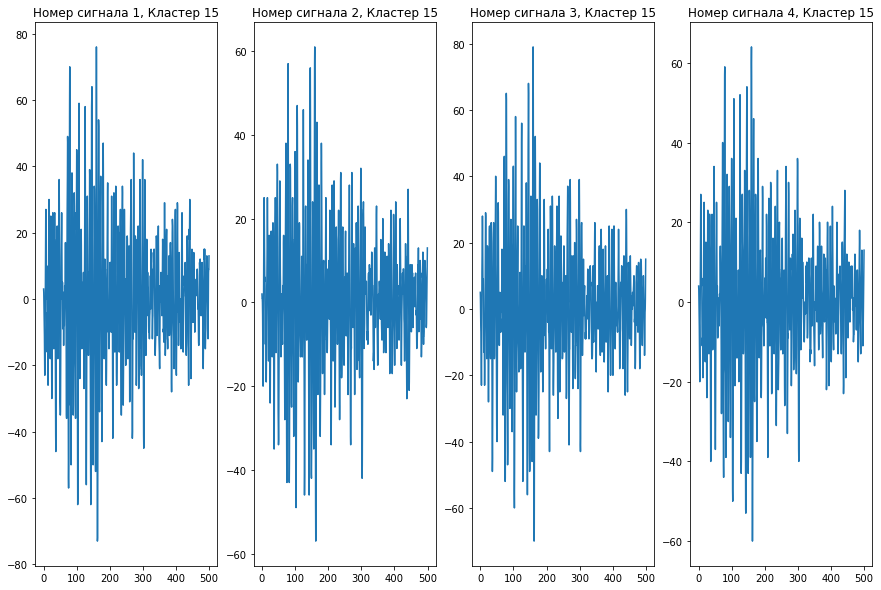

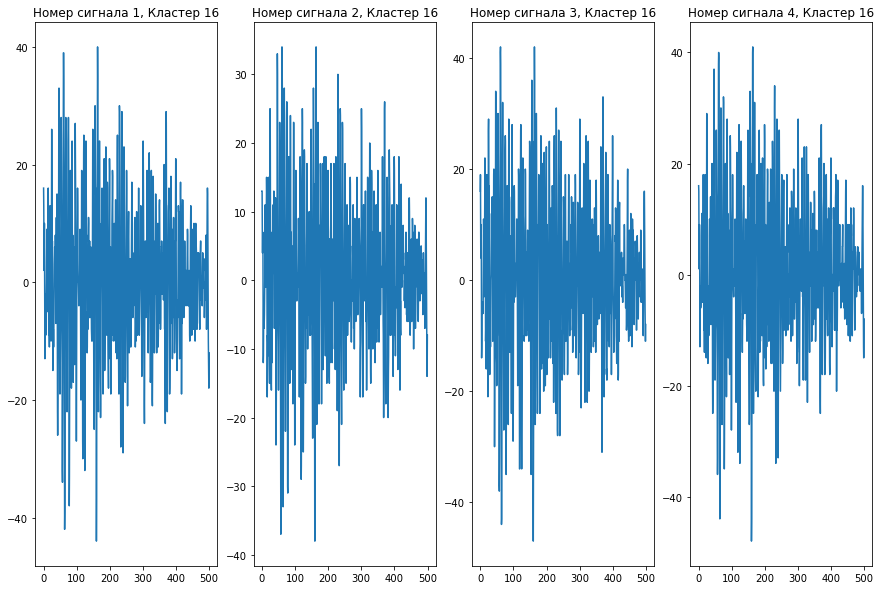

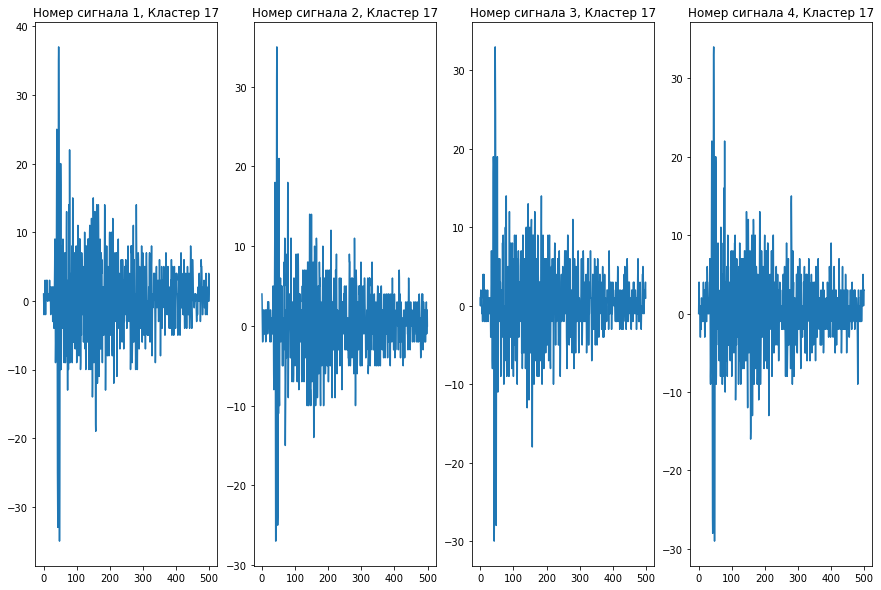

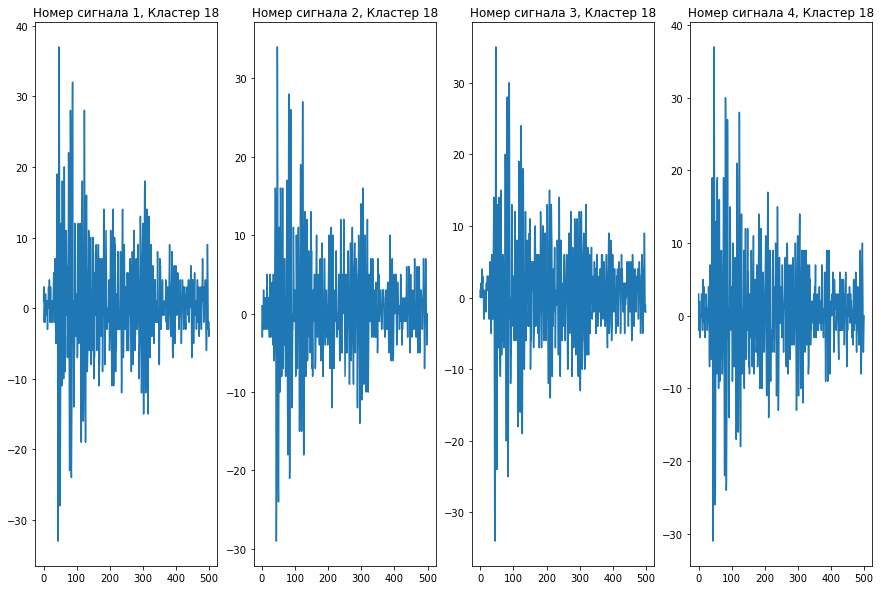

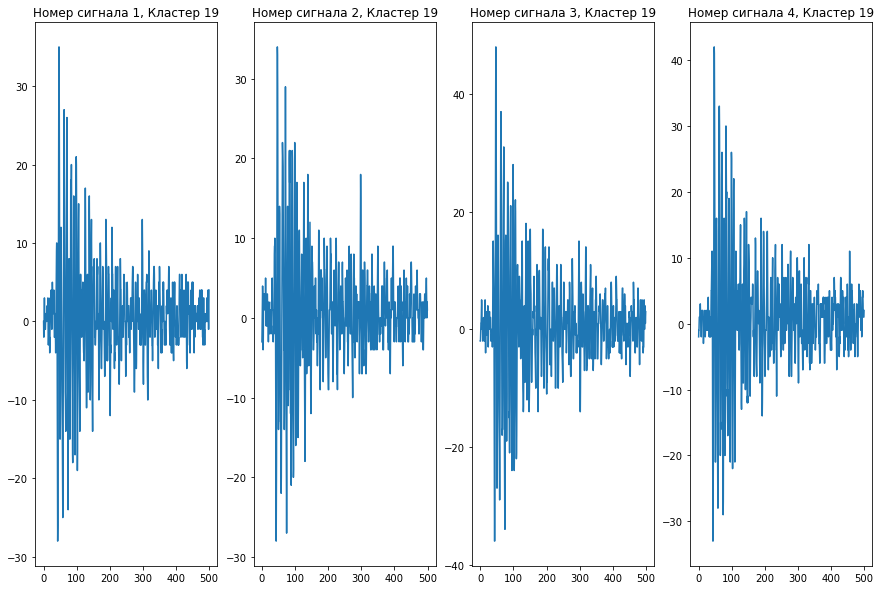

In [42]:
list_labels = list(np.unique(clustering.labels_))
number = list(range(len(np.unique(clustering.labels_))))
for i, labels in zip(number, list_labels):
    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for j in range(0, 4):
        axes[j].plot(time, dataset.iloc[np.where(clustering.labels_== labels)].iloc[j])
        axes[j].set_title("Номер сигнала {}, Кластер {}".format(j+1, labels))

Решение задачи по определению распределения сигналов акустической эмиссии, относящихся к каждому кластеру, классифицированных по форме сигнала, в пространстве "Амплитуда" - "Время". Открытие, чтение файла, содержащего информацию о времени регистрации сигналов акустической эмисии, в отношении которых использовалась информация о форме сигнала.

In [43]:
f = open(r'C:\Users\homepc\Documents\Pyton\aem14_01_13#02_osc_1.txt', 'r', encoding="utf-16")
frame_head = pd.read_table(f, sep ='\s+', names = ['Number of signal', 'Date', 'Time', 'Number of channel', 'Window', 'Frequency', 'Size',
                                             'Duration', 'Pretrigg', 'Syncing', 'Threshold, ADC', 'Threshold, dB'])
f.close()

Преобразование данных в стобце "Time" в формат Datetime. Каждая строка объекта DataFrame "frame_head" содержит информацию о сигнале акустической эмисии, информация о форме которого приведена в объекте DataFrame "dataset". Количество строк объекта DataFrame "frame_head" соответствует количеству строк объекта DataFrame "frame_head" и равно количеству сигналов акустической эмисии, в отношении которых был реализован алгоритм кластеризации.  

In [44]:
data_time = frame_head['Date'] + ' ' + frame_head['Time']
frame_head['Time'] = data_time
f = lambda x: datetime.strptime(x, '%d.%m.%y %H:%M:%S.%f')
data_time = frame_head['Time'].apply(f).to_frame(name = 'Time')
frame_head['Time'] = data_time
frame_head = frame_head.drop('Date', axis = 1)
frame_head

Number of signal                       Time  Number of channel  Window  \
0                    1 2013-01-14 10:53:12.967443                  1       1   
1                    2 2013-01-14 10:53:13.103898                  2       2   
2                    3 2013-01-14 10:53:13.126401                  1       1   
3                    4 2013-01-14 10:53:13.232274                  2       2   
4                    5 2013-01-14 10:53:13.248634                  1       1   
...                ...                        ...                ...     ...   
4818              4819 2013-01-14 15:39:00.939129                  1       1   
4819              4820 2013-01-14 15:39:01.511144                  1       1   
4820              4821 2013-01-14 15:39:12.725118                  1       1   
4821              4822 2013-01-14 15:39:12.725115                  2       2   
4822              4823 2013-01-14 15:39:16.636845                  1       1   

      Frequency  Size  Duration  Pretrigg  Syncing  Threshold, ADC  \
0          2000  1000       500       100  асинхр.              33   
1          2000  1000       500       100  асинхр.              33   
2          2000  1000       500       100  асинхр.              33   
3          2000  1000       500       100  асинхр.              33   
4          2000  1000       500       100  асинхр.              33   
...         ...   ...       ...       ...      ...             ...   
4818       2000  1000       500       100  асинхр.              33   
4819       2000  1000       500       100  асинхр.              33   
4820       2000  1000       500       100  асинхр.              33   
4821       2000  1000       500       100  асинхр.              33   
4822       2000  1000       500       100  асинхр.              33   

      Threshold, dB  
0         40.082012  
1         40.082012  
2         40.082012  
3         40.082012  
4         40.082012  
...             ...  
4818      40.082012  
4819      40.082012  
4820      40.082012  
4821      40.082012  
4822      40.082012  

[4823 rows x 11 columns]

Формирование словаря, в котором в качестве ключа выступает номер кластера, определенного при кластеризации, в качестве значений выступает список индексов сигналов акустической эмиссии, отнесенных к данному кластеру.   

In [45]:
list_labels = list(np.unique(clustering.labels_))
dict_index = {}
index_list = list(frame['Time'].index)
frame_head = frame_head.set_index(frame_head['Number of signal'])
for label in list_labels:
    list_index = []
    for x in frame_head.loc[dataset.iloc[np.where(clustering.labels_== label)].index]['Time']:
        for y, i in zip(frame['Time'], index_list):
            if x == y:
                list_index.append(i)
        dict_index[label] = list_index

Построение графика зависимости амплитуды сигналов акустической эмисии от времени для каждого кластера, сформированного при кластеризации по форме сигналов акустической эмиссии.

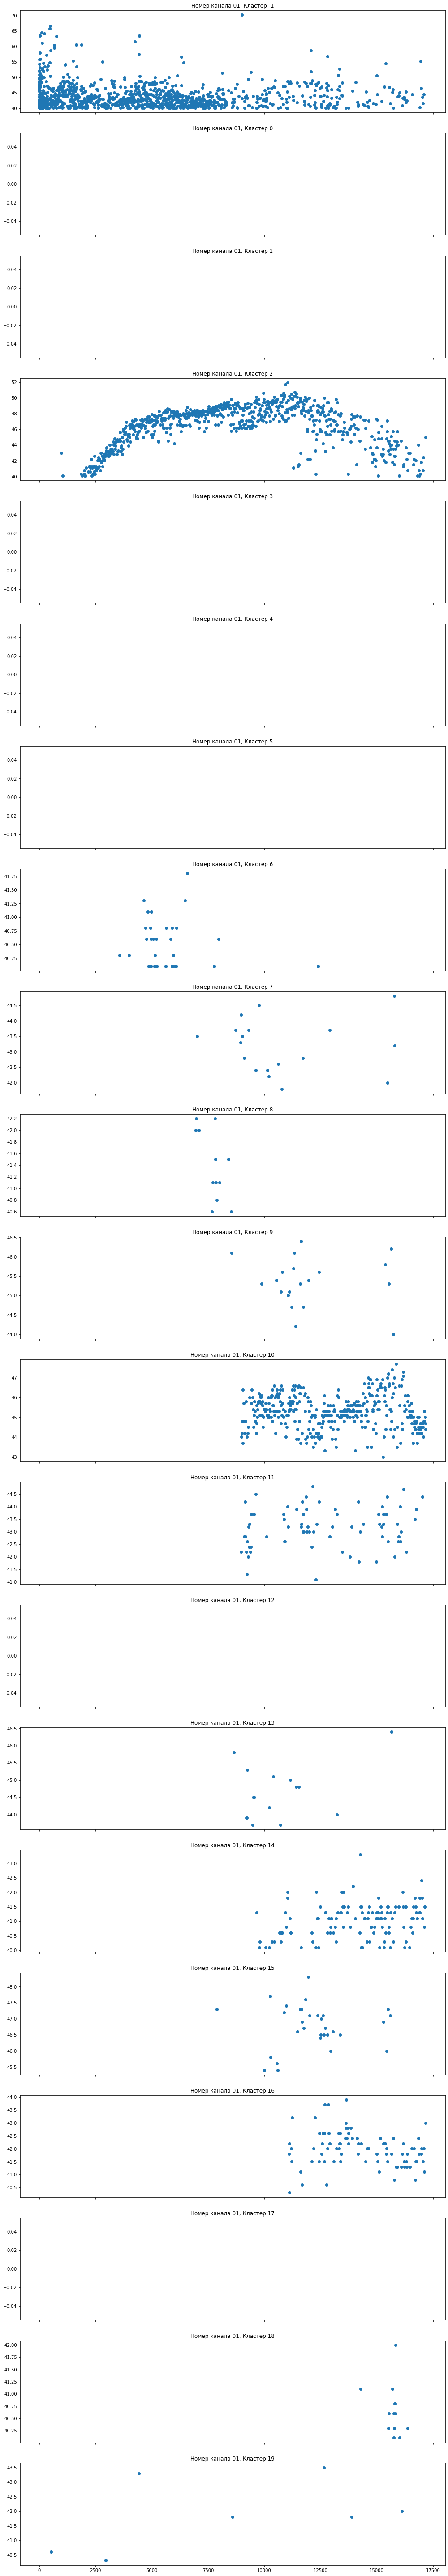

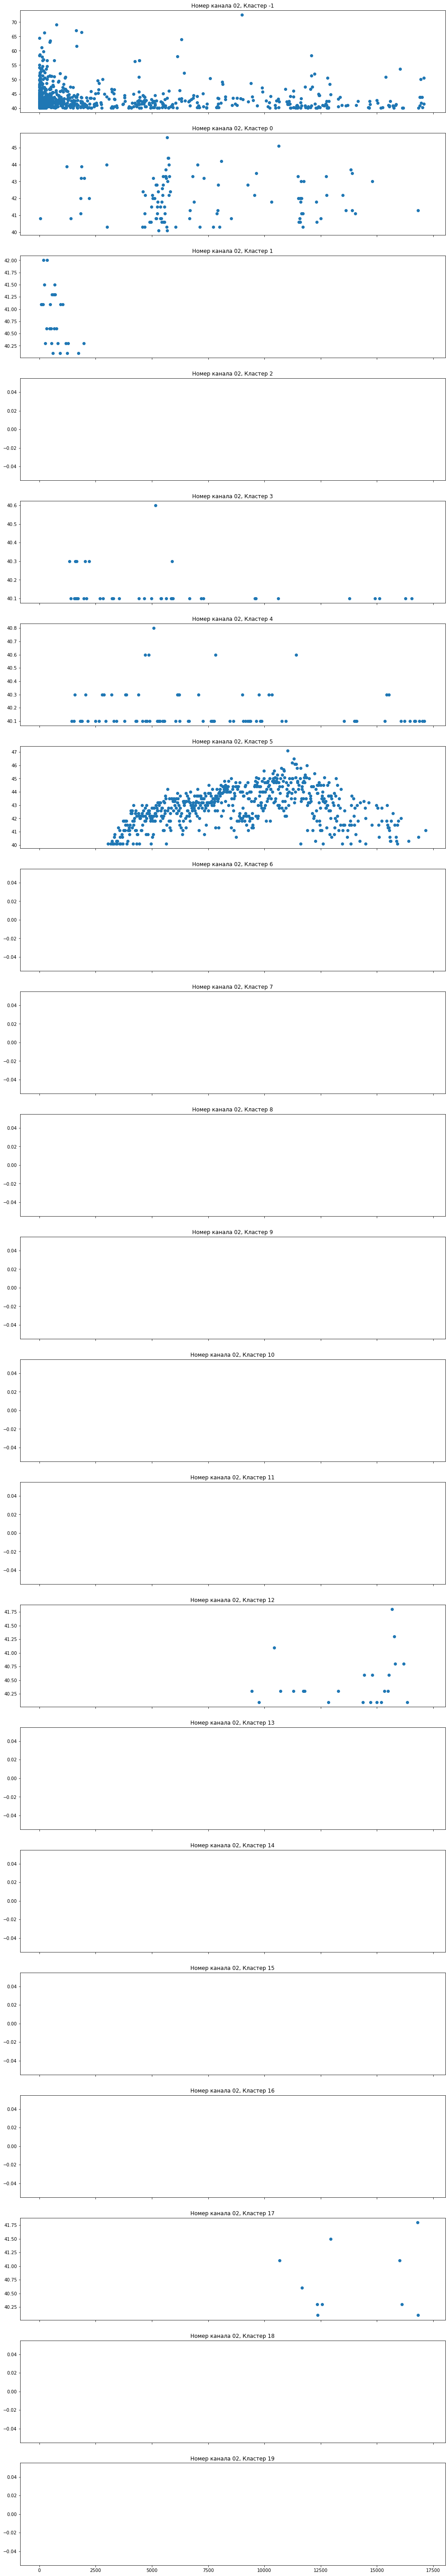

In [46]:
for number_of_channel in ['01', '02']:
    number = list(range(len(np.unique(clustering.labels_))))
    fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
    list_labels = list(np.unique(clustering.labels_))
    for i, labels in zip(number, list_labels):
        axes[i].scatter(frame.loc[dict_index[labels]].loc[frame['Number of channel'] == number_of_channel]['Time relative'], 
           frame.loc[dict_index[labels]].loc[frame['Number of channel'] == number_of_channel]['Amplitude, dB'])
        axes[i].set_title("Номер канала {}, Кластер {}".format(number_of_channel, labels))

По результатам анализа графиков установлено, что, исключая кластер шума с номером "-1", алгоритм кластеризации по форме сигнала разделил сигналы по номерам каналов их регистрации.

Для получения более информативных результатов кластеризации подадим на вход алгоритма кластеризации DBSCAN информацию о форме сигналов акустической эмиссии, разделенных по разным каналам кластеризации.
Кластеризация сигналов акустической эмиссии по форме сигнала для первого канала регистрации.

In [47]:
frame_head = frame_head.set_index(frame_head['Number of signal'])
dataset_01 = dataset.loc[frame_head[frame_head['Number of channel'] == 1].index]
X = dataset_01
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
clustering = DBSCAN(eps=8, min_samples=5).fit(X_scaled)

Отображение первых четырех сигналов акустической эмисии, входящих в каждый кластер для первого канала регистрации.

<ipython-input-48-e869e8c36a1d>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 4, figsize=(15, 10))


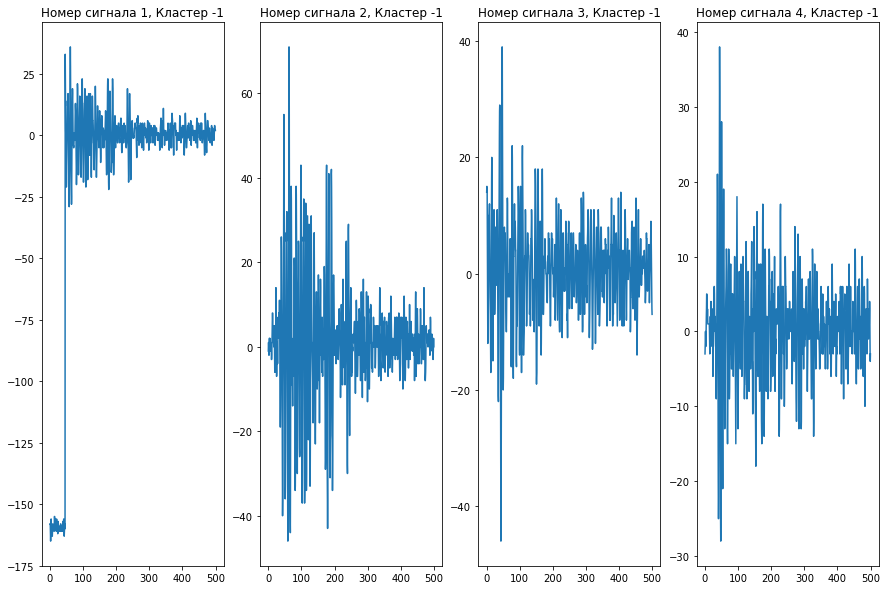

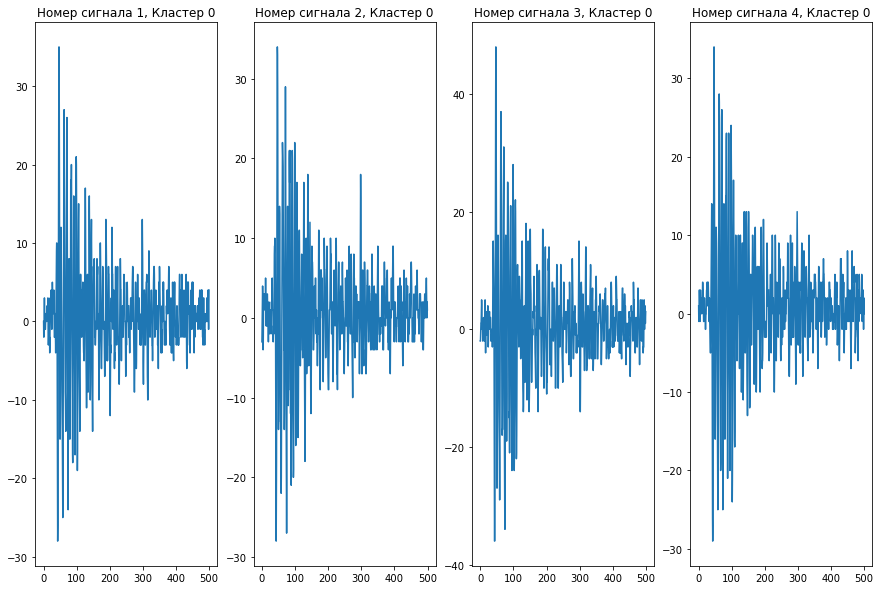

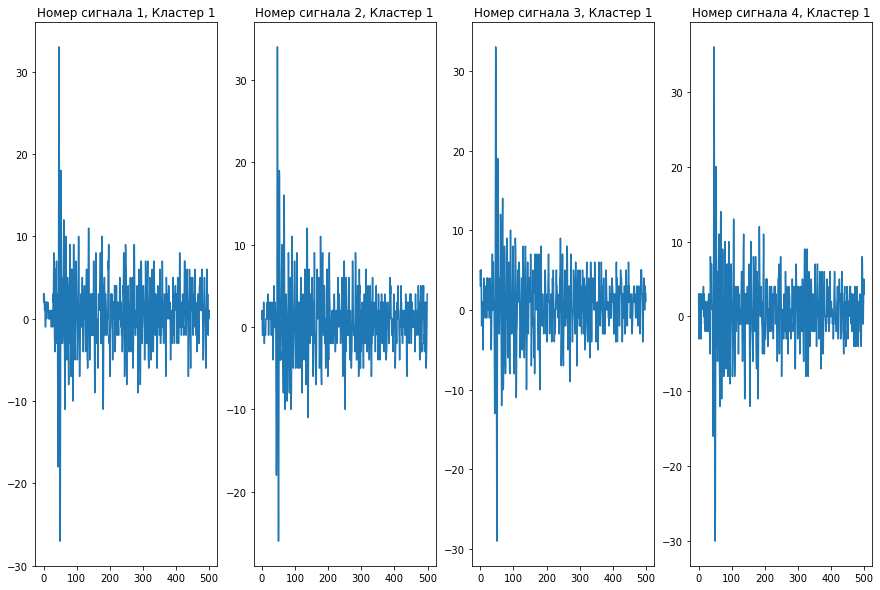

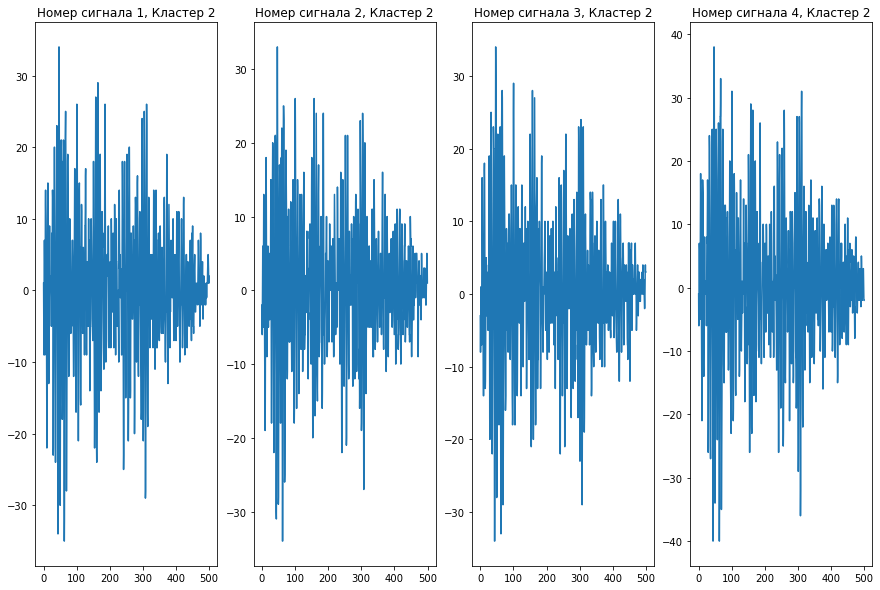

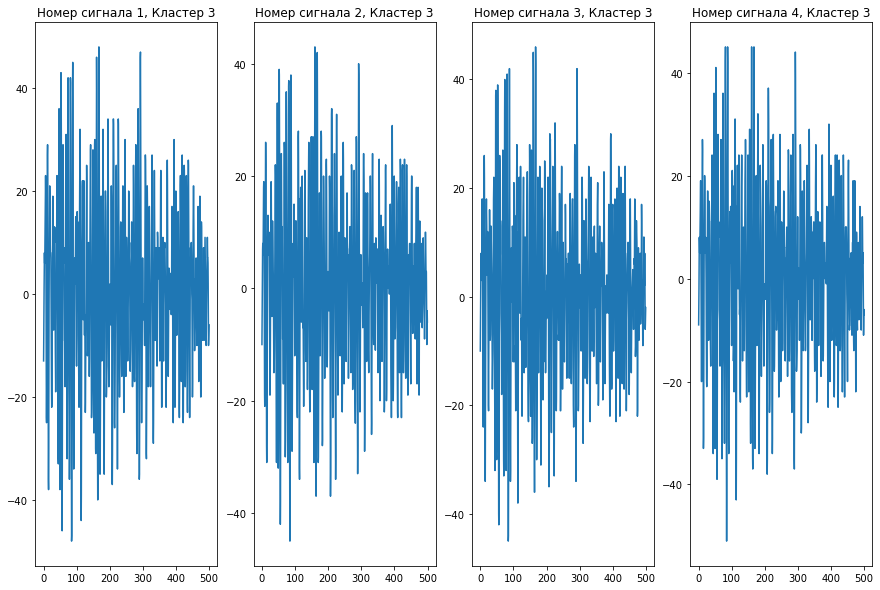

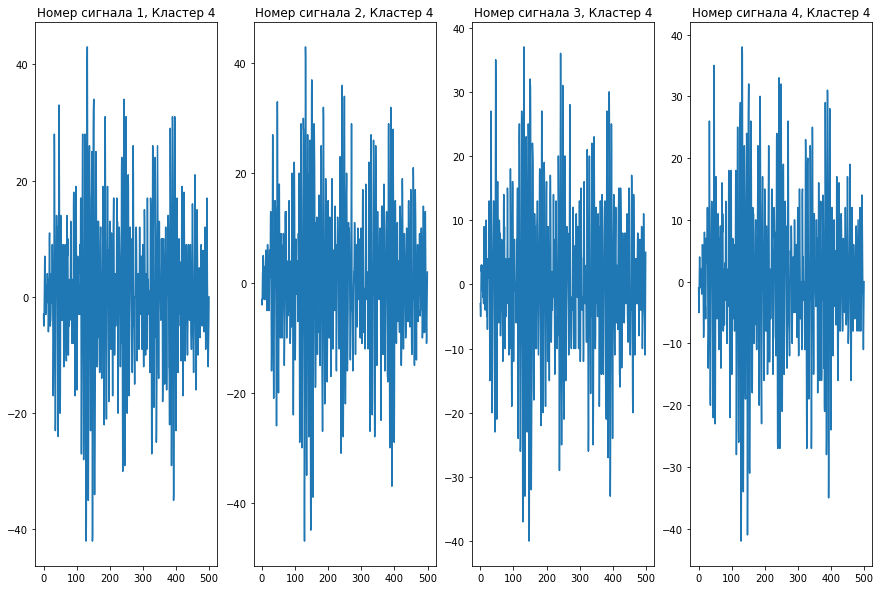

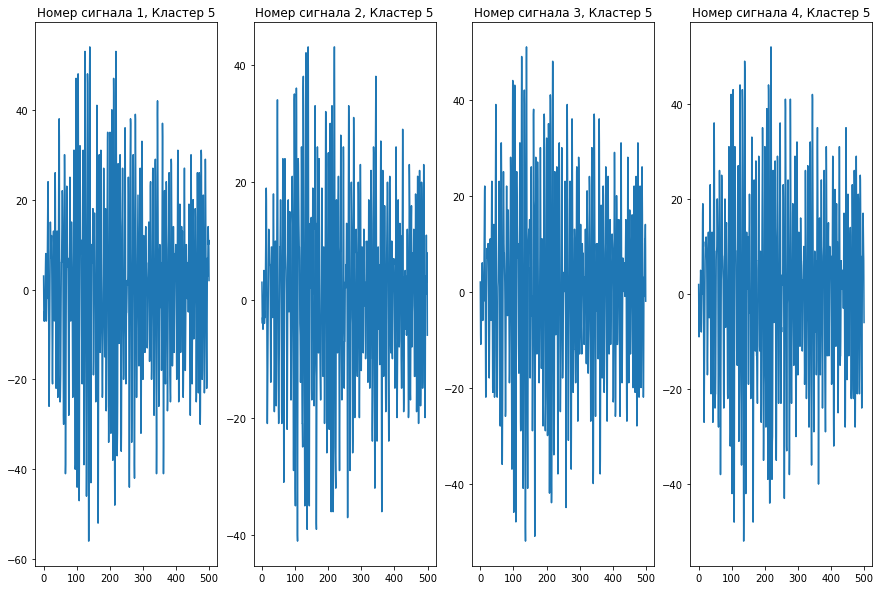

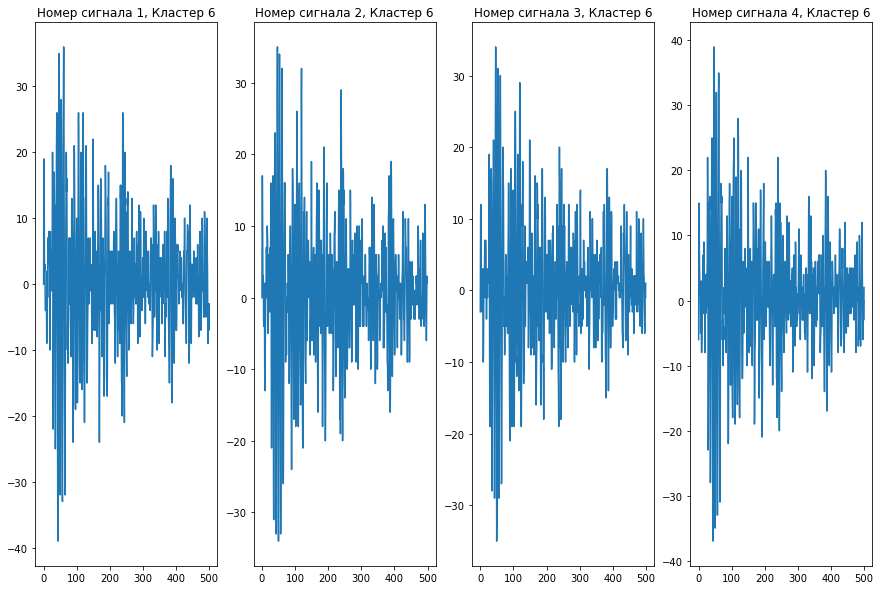

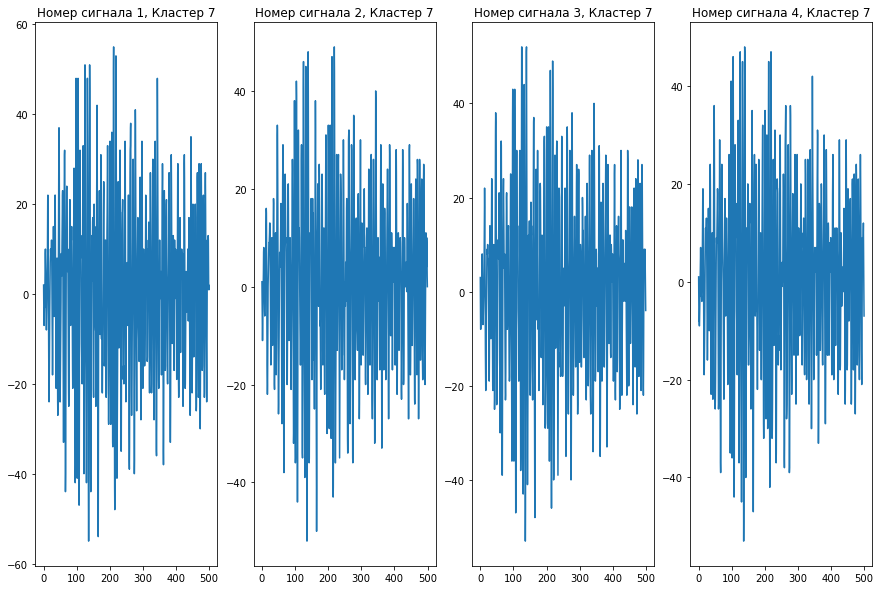

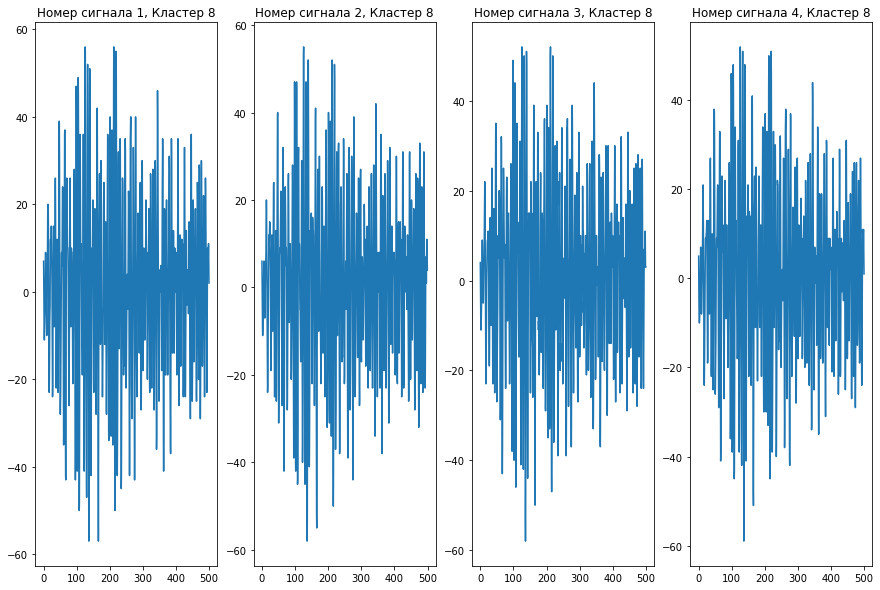

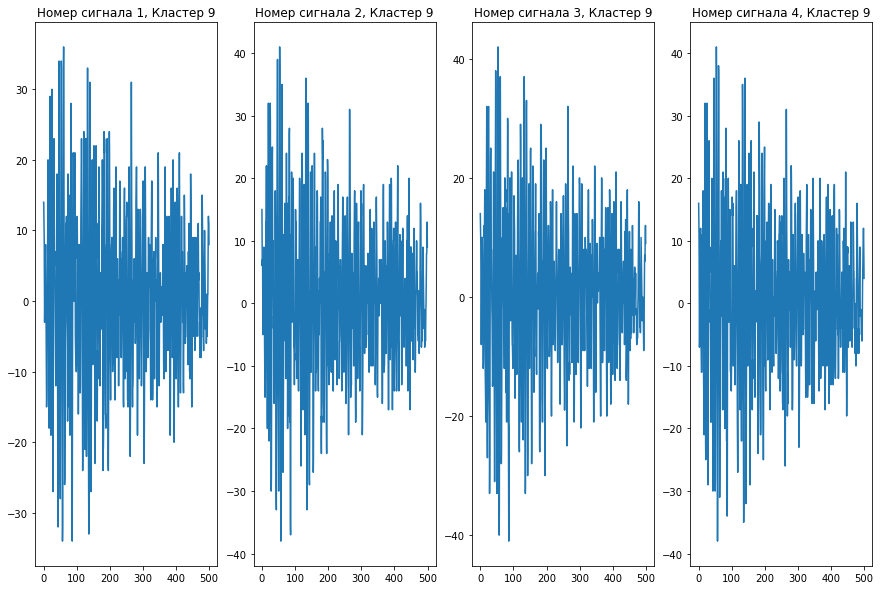

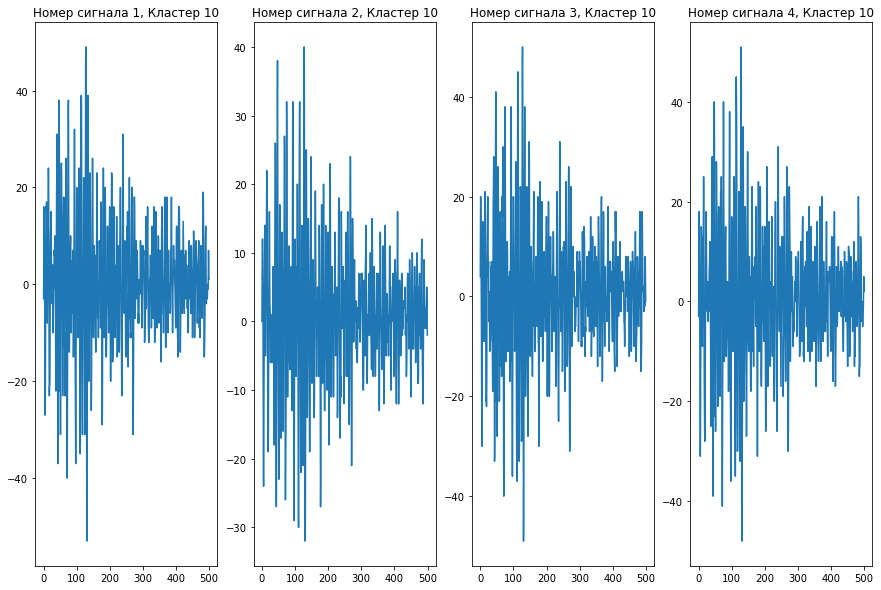

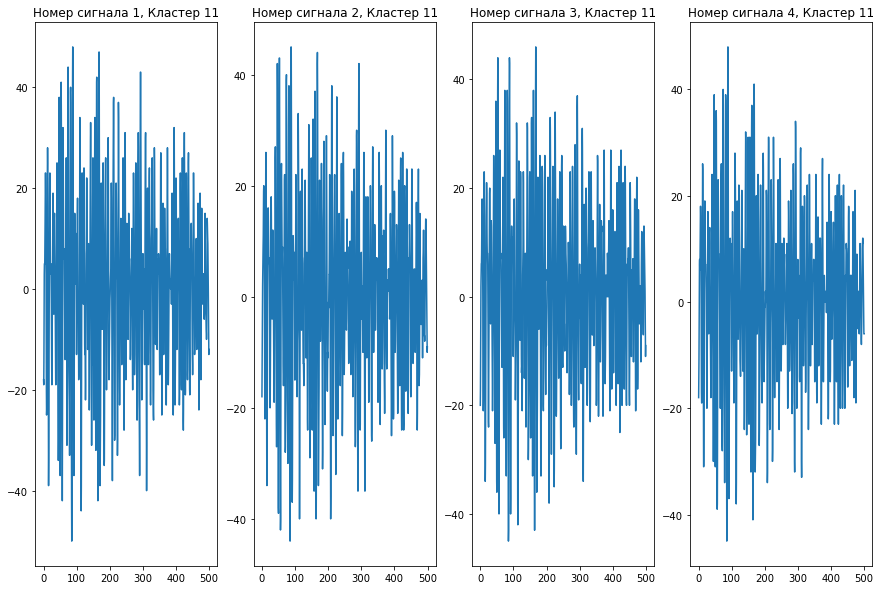

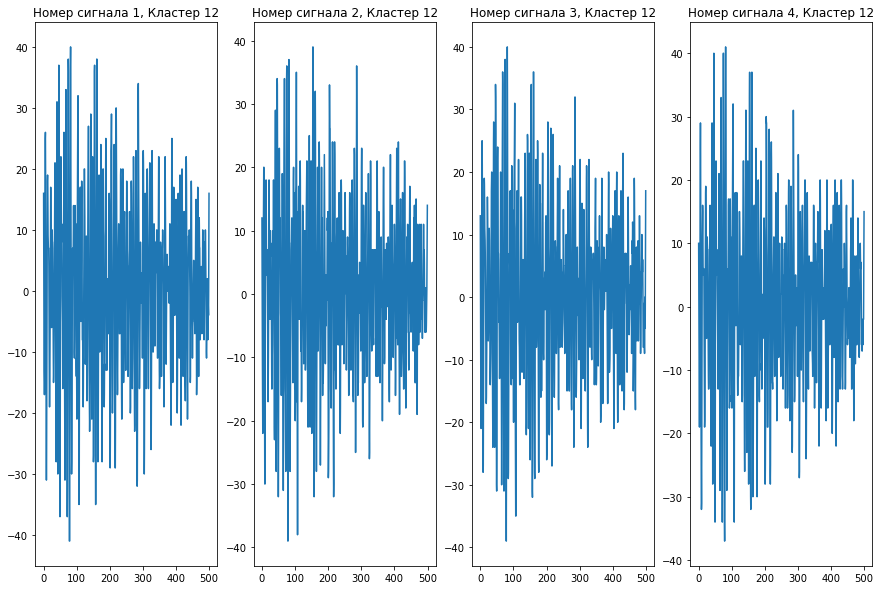

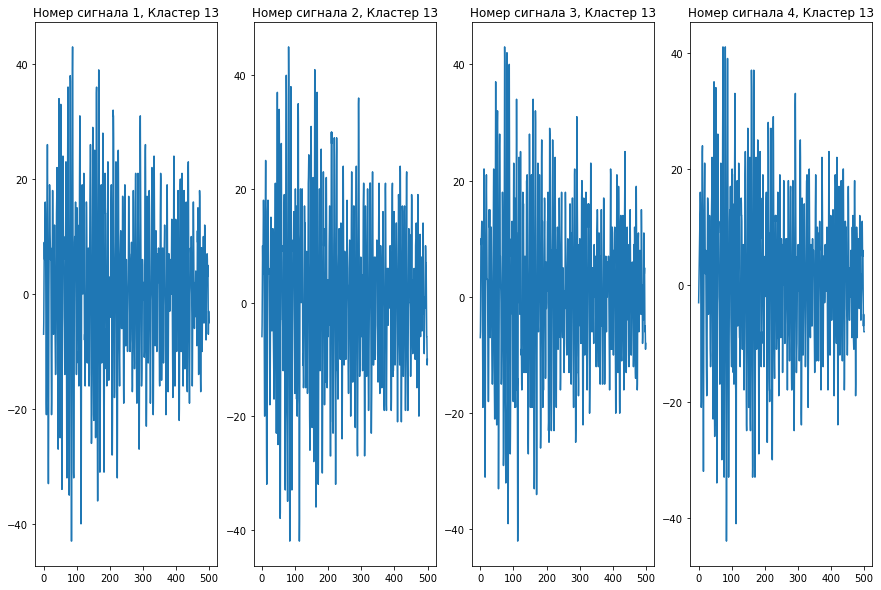

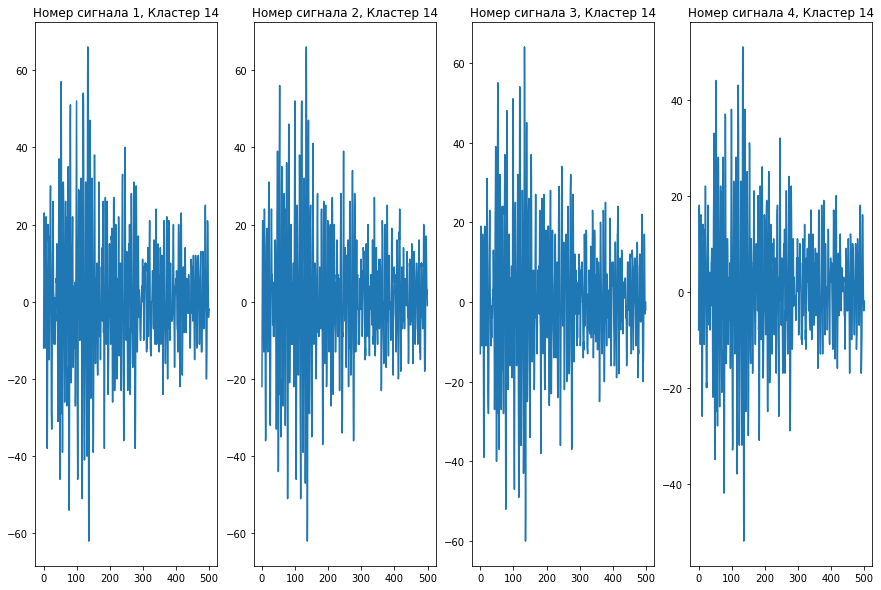

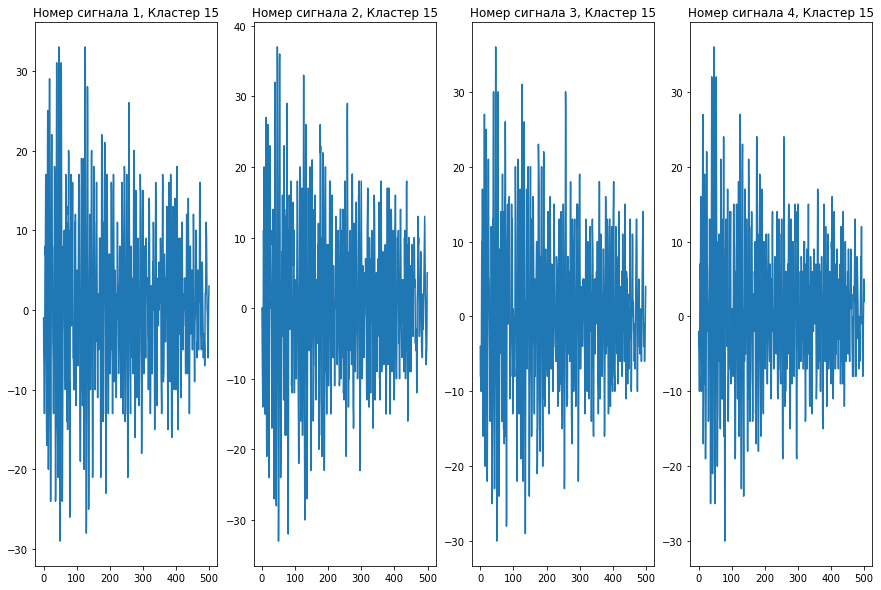

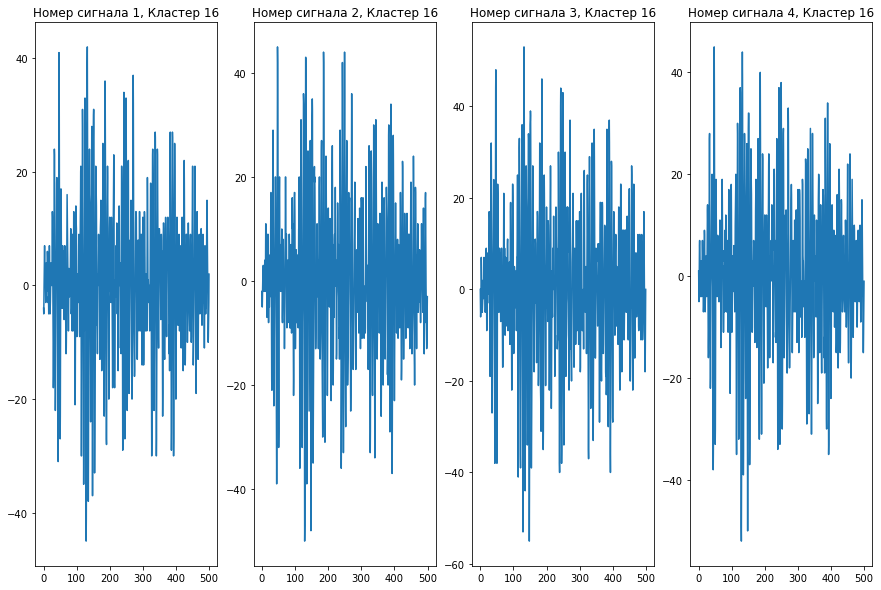

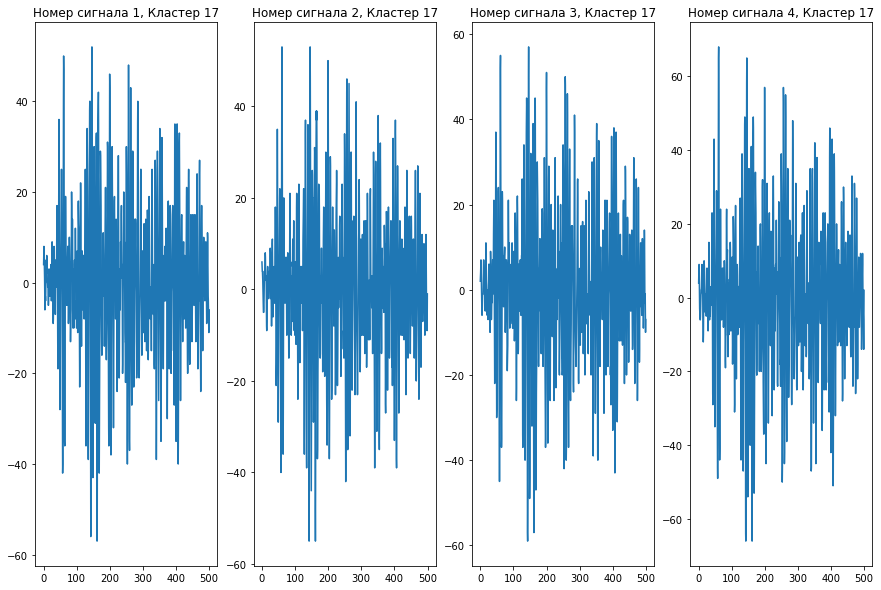

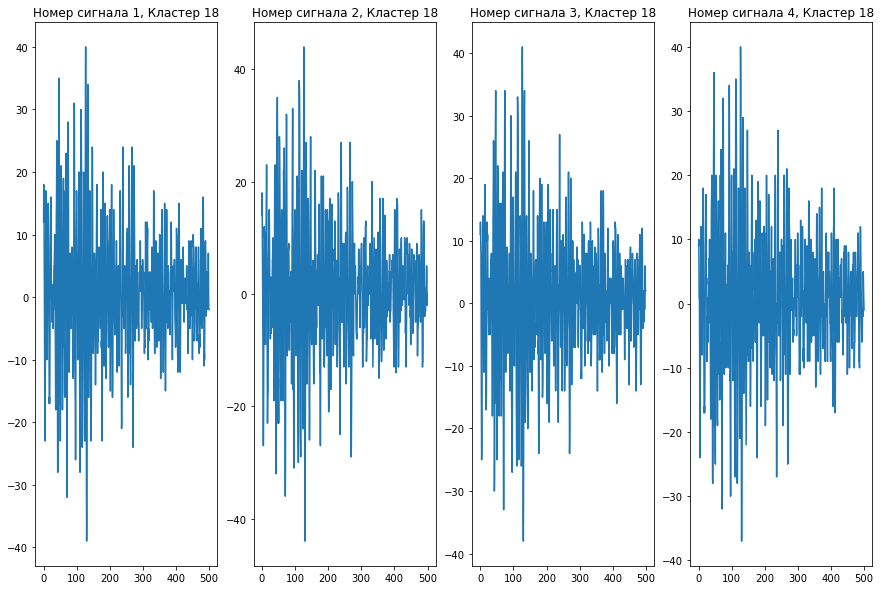

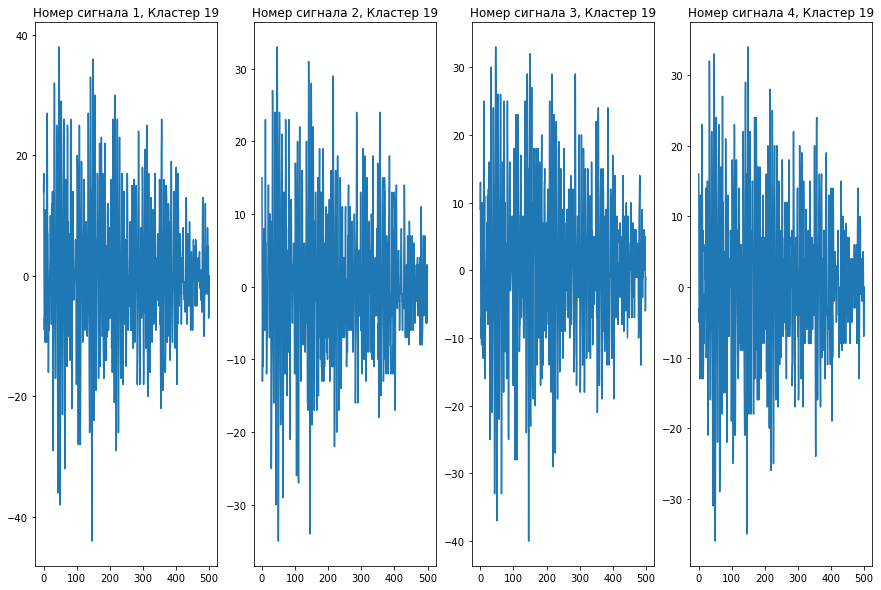

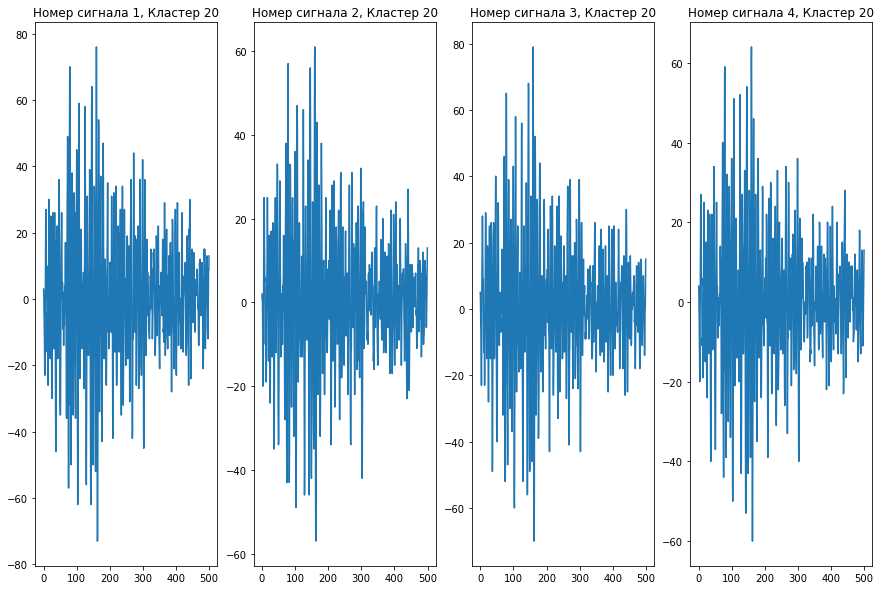

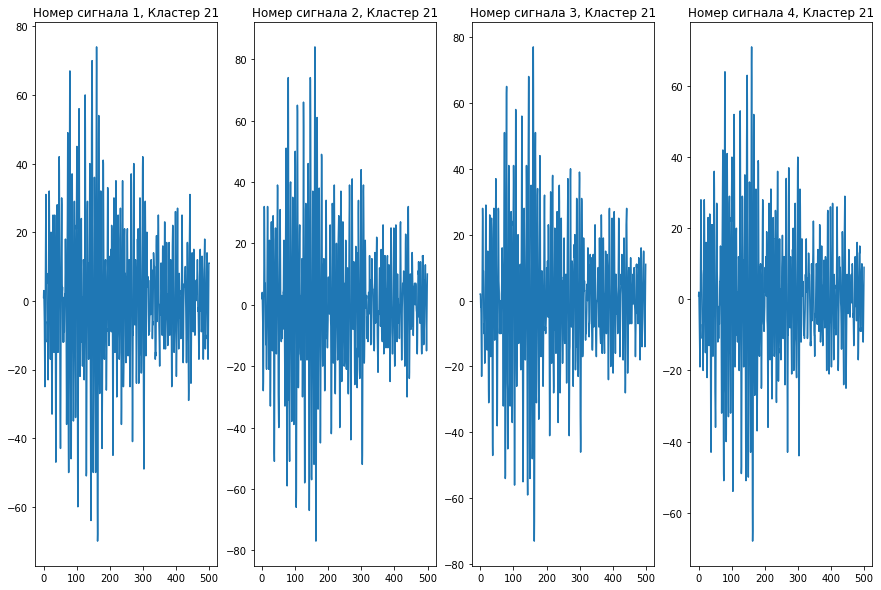

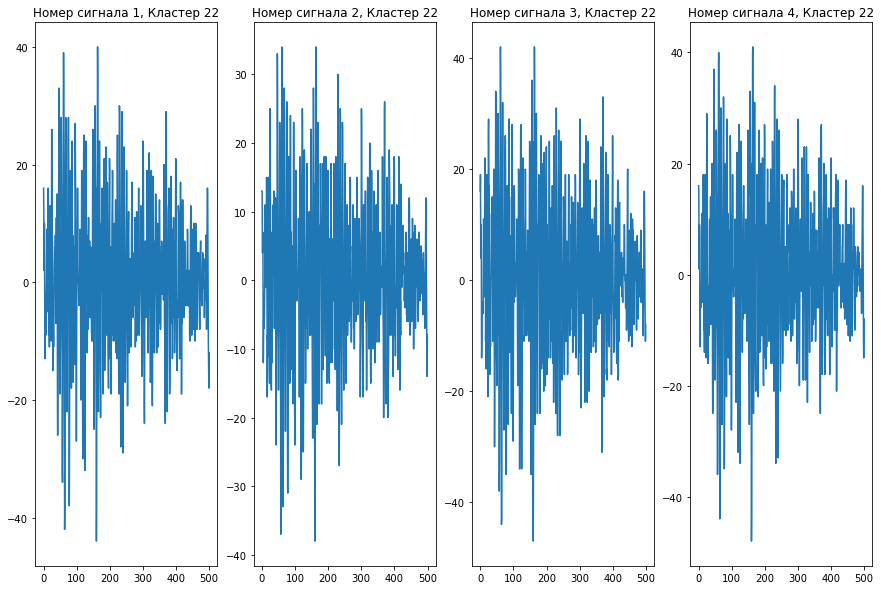

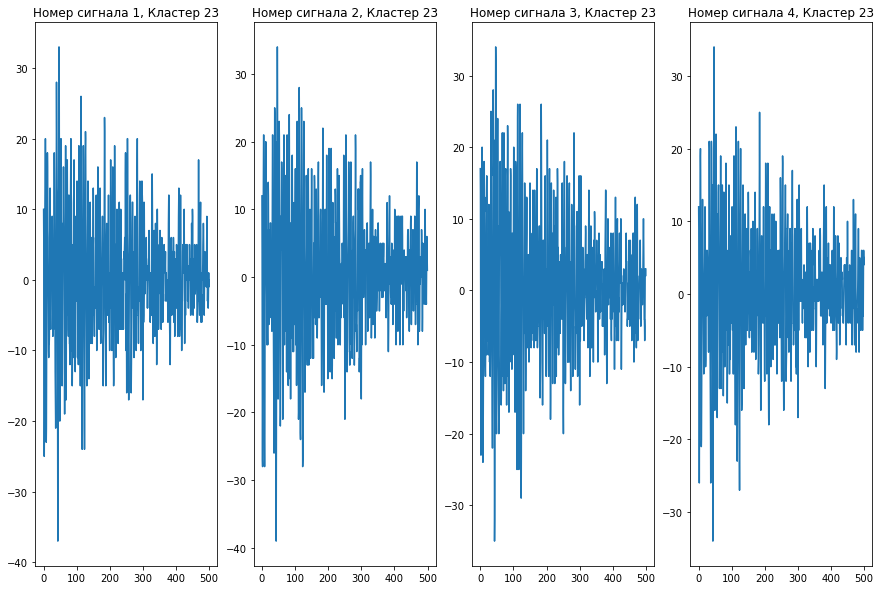

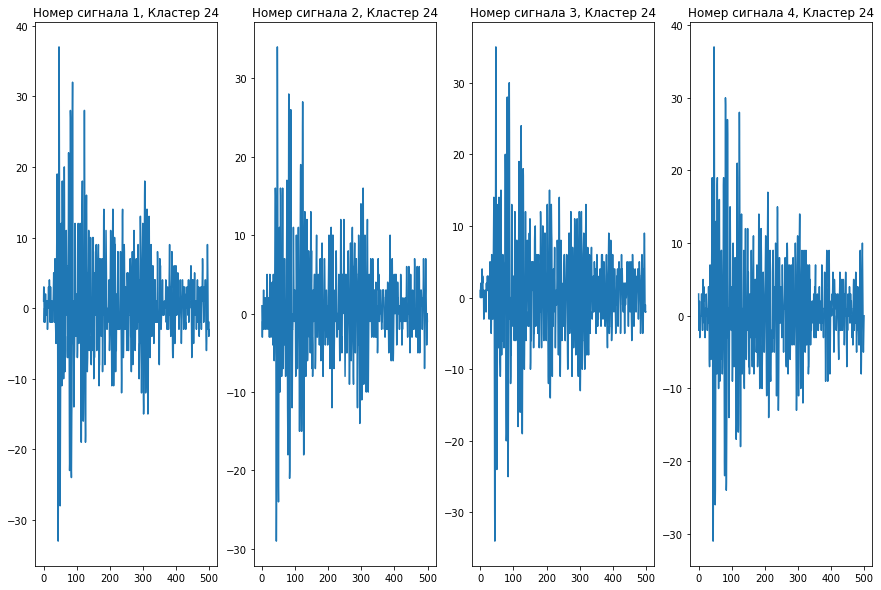

In [48]:
list_labels = list(np.unique(clustering.labels_))
number = list(range(len(np.unique(clustering.labels_))))
for i, labels in zip(number, list_labels):
    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for j in range(0, 4):
        axes[j].plot(time, dataset_01.iloc[np.where(clustering.labels_== labels)].iloc[j])
        axes[j].set_title("Номер сигнала {}, Кластер {}".format(j+1, labels))

Формирование словаря, в котором в качестве ключа выступает номер кластера, определенного при кластеризации, в качестве значений выступает список индексов сигналов акустической эмиссии, отнесенных к данному кластеру для первого канала регистрации.

In [49]:
list_labels = list(np.unique(clustering.labels_))
dict_index = {}
index_list = list(frame['Time'].index)
frame_head = frame_head.set_index(frame_head['Number of signal'])
for label in list_labels:
    list_index = []
    for x in frame_head.loc[dataset_01.iloc[np.where(clustering.labels_== label)].index]['Time']:
        for y, i in zip(frame['Time'], index_list):
            if x == y:
                list_index.append(i)
        dict_index[label] = list_index

Построение графика зависимости амплитуды сигналов акустической эмисии от времени для каждого кластера, сформированного при кластеризации по форме сигналов акустической эмиссии для первого канала регистрации.

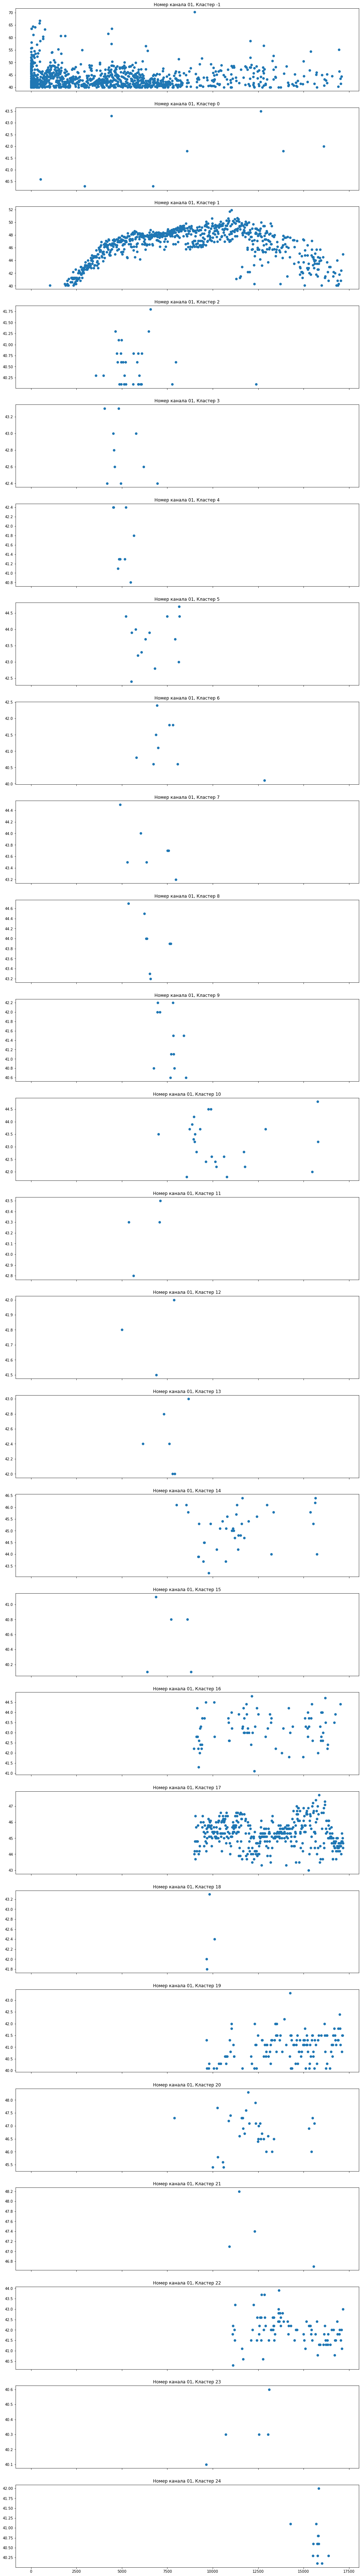

In [50]:
number = list(range(len(np.unique(clustering.labels_))))
fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
list_labels = list(np.unique(clustering.labels_))
for i, labels in zip(number, list_labels):
    axes[i].scatter(frame.loc[dict_index[labels]].loc[frame['Number of channel'] == '01']['Time relative'], 
               frame.loc[dict_index[labels]].loc[frame['Number of channel'] == '01']['Amplitude, dB'])
    axes[i].set_title("Номер канала 01, Кластер {}".format(labels))

Кластеризация сигналов акустической эмиссии по форме сигнала с помощью алгоритма DBSCAN для второго канала регистрации.

In [51]:
dataset_02 = dataset.loc[frame_head[frame_head['Number of channel'] == 2].index]
X = dataset_02
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
clustering = DBSCAN(eps=8, min_samples=5).fit(X_scaled)

Отображение первых четырех сигналов акустической эмисии, входящих в каждый кластер для второго канала регистрации.

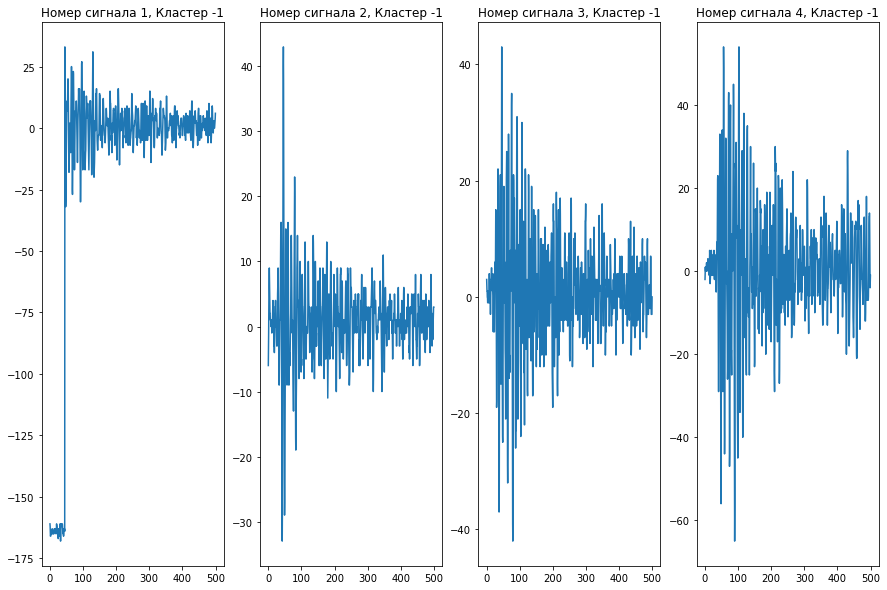

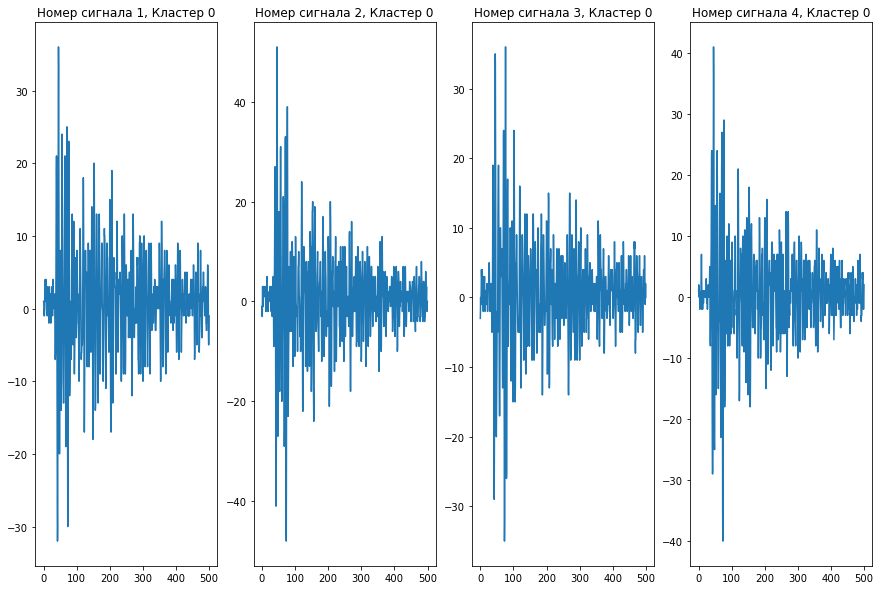

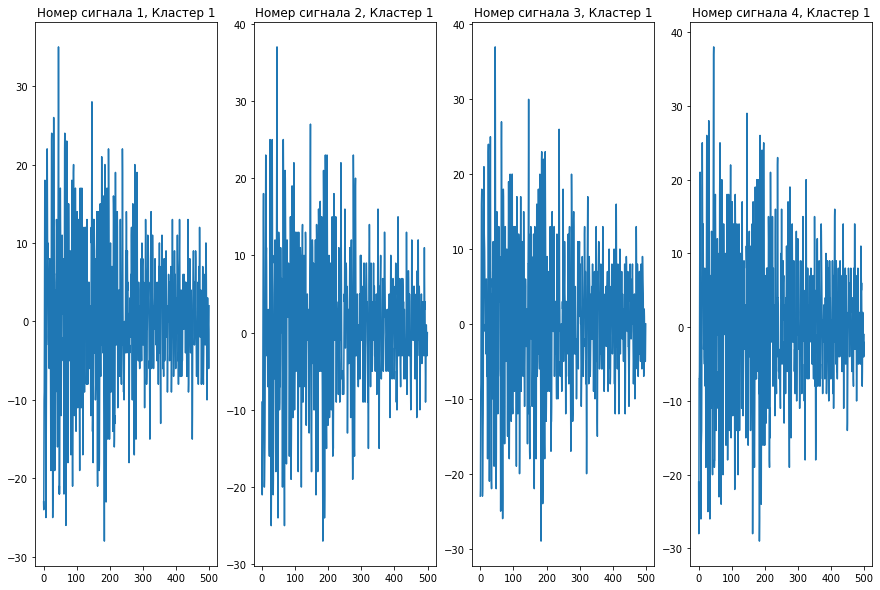

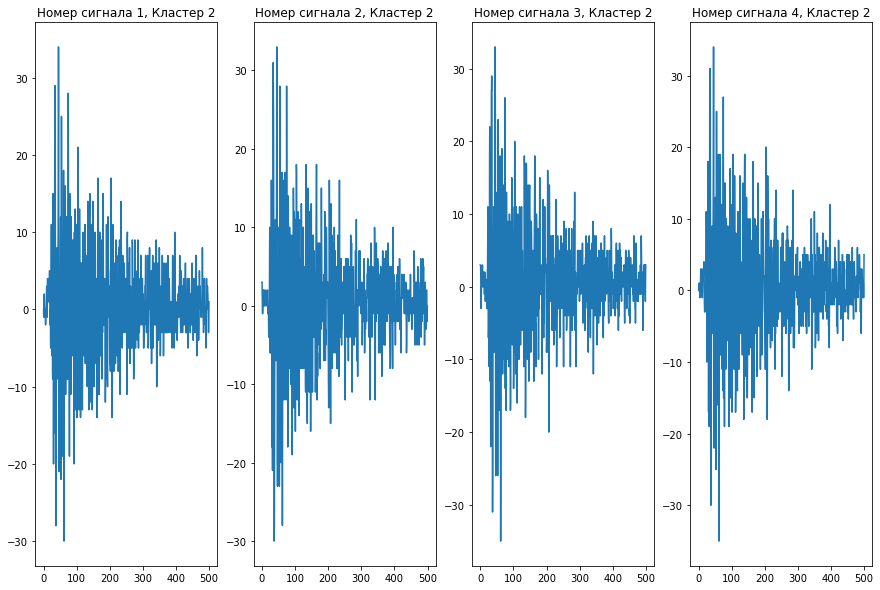

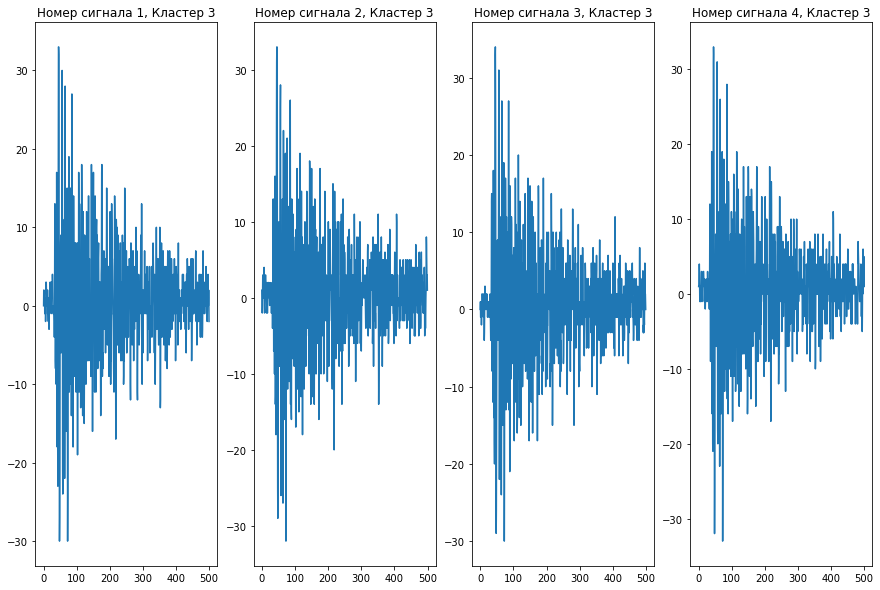

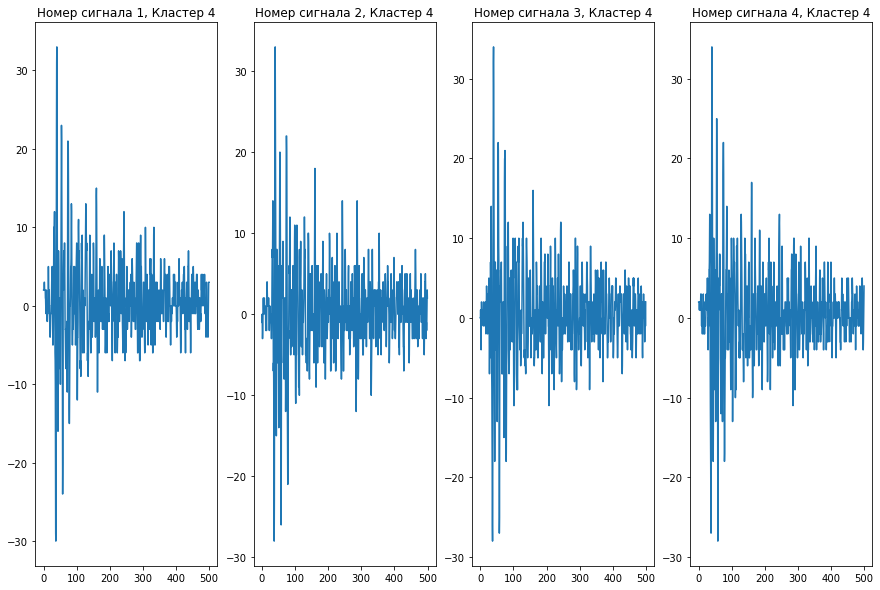

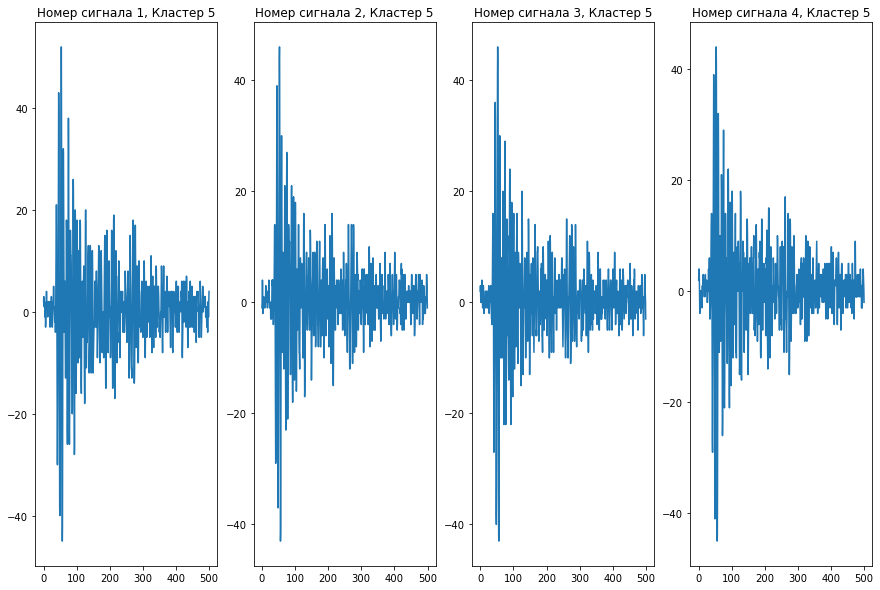

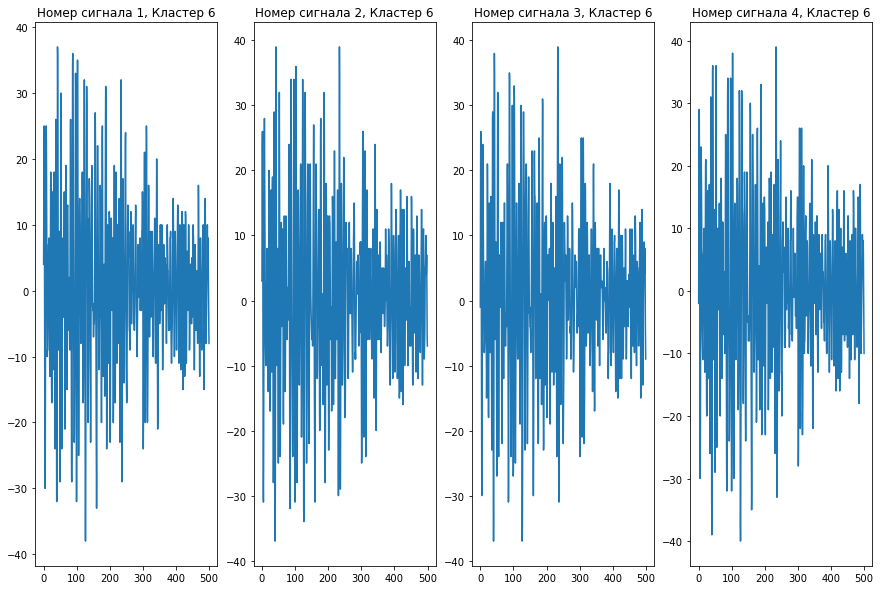

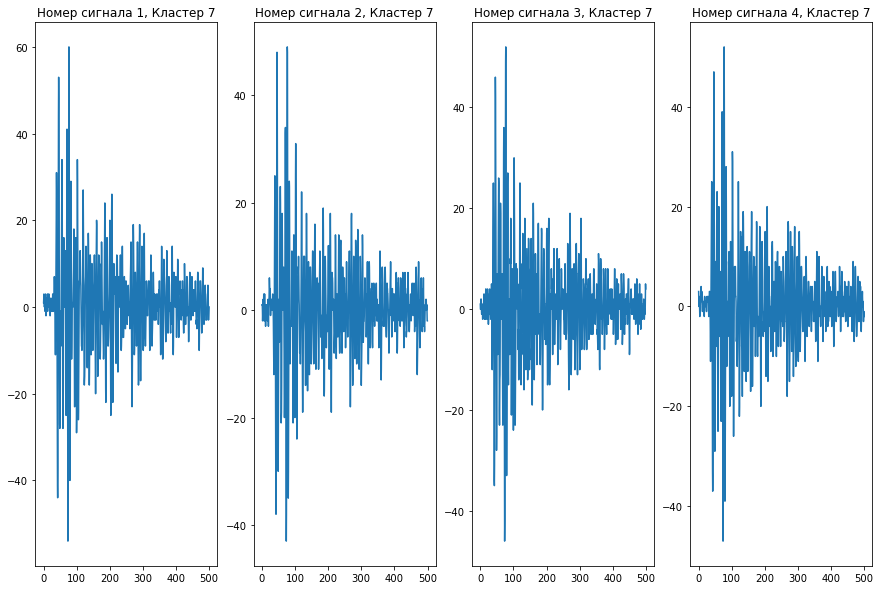

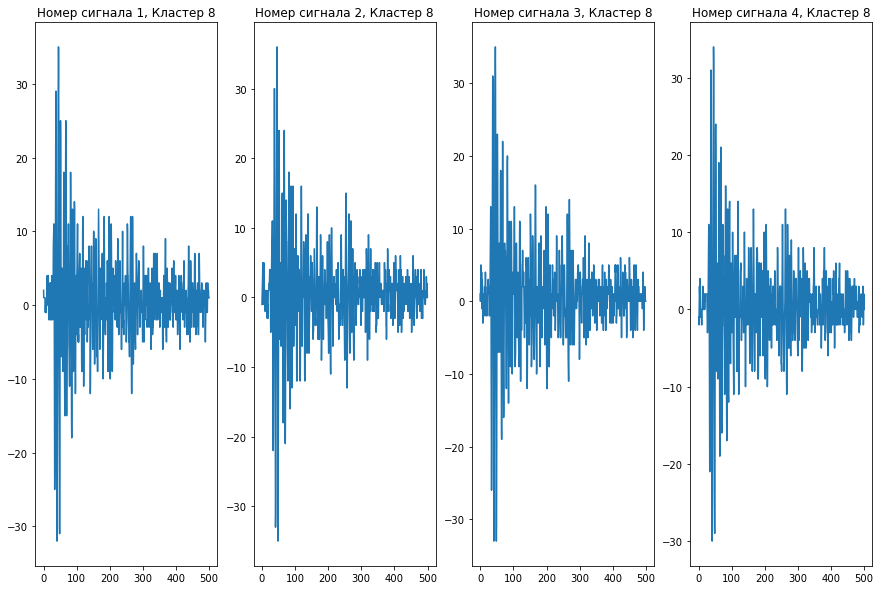

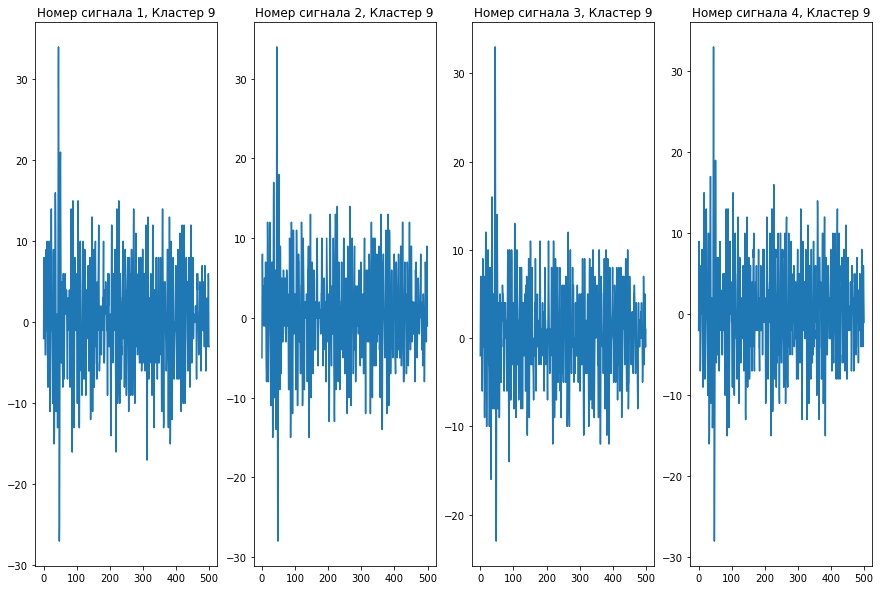

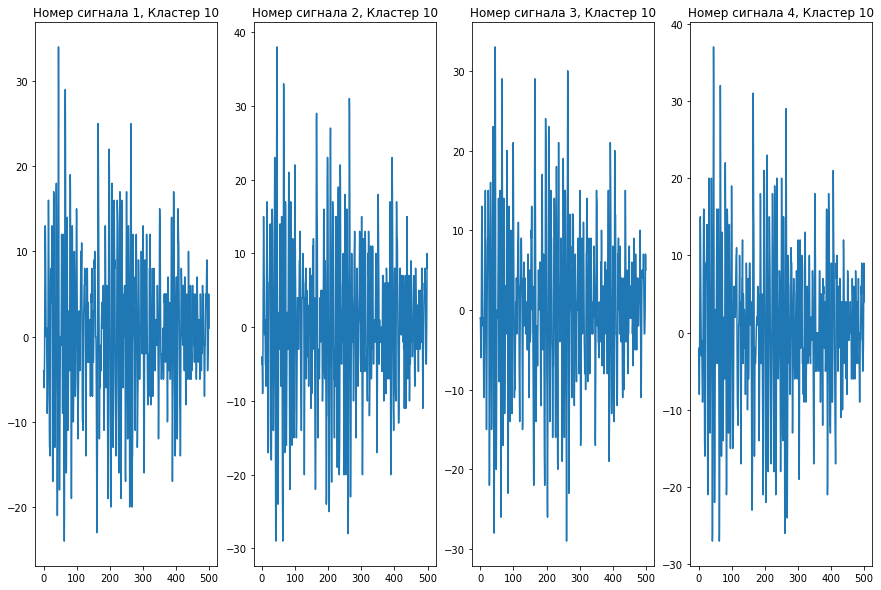

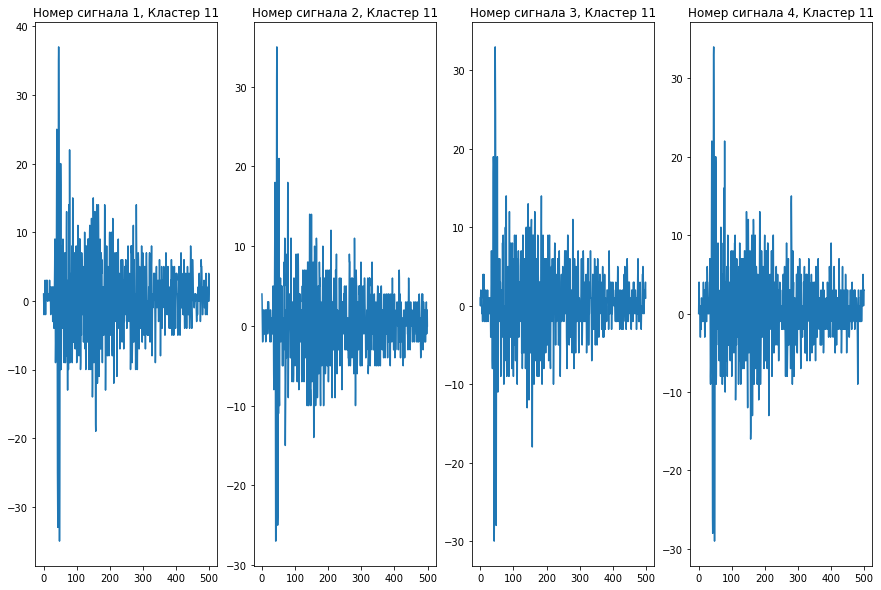

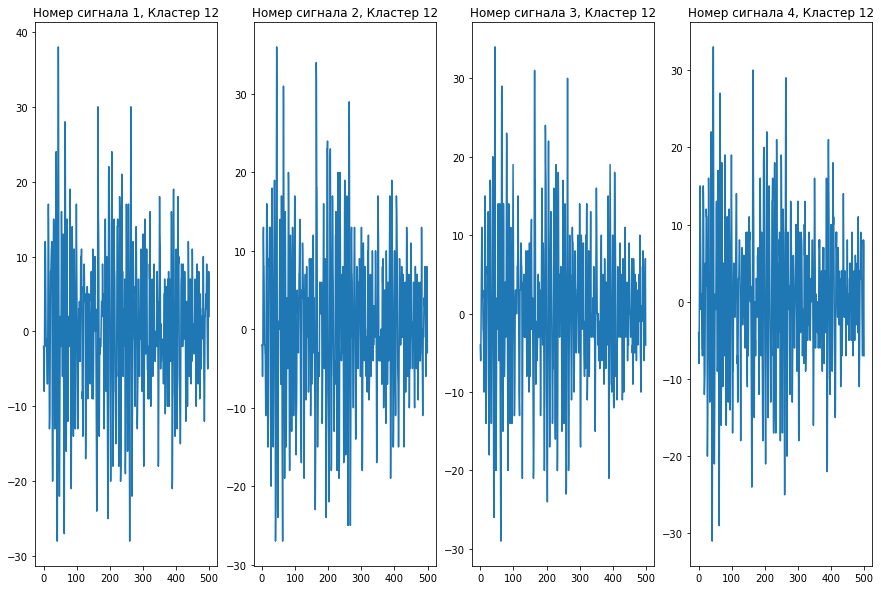

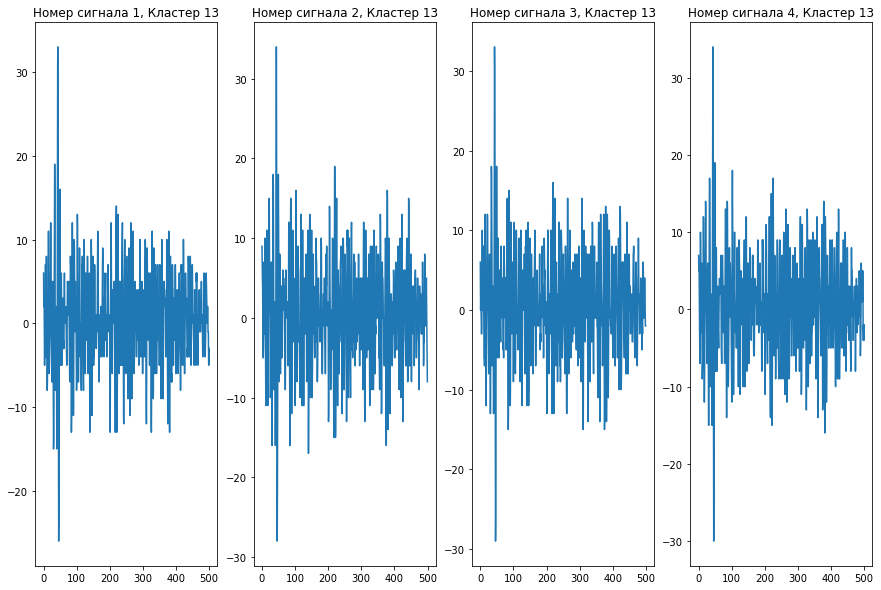

In [52]:
list_labels = list(np.unique(clustering.labels_))
number = list(range(len(np.unique(clustering.labels_))))
for i, labels in zip(number, list_labels):
    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for j in range(0, 4):
        axes[j].plot(time, dataset_02.iloc[np.where(clustering.labels_== labels)].iloc[j])
        axes[j].set_title("Номер сигнала {}, Кластер {}".format(j+1, labels))

Формирование словаря, в котором в качестве ключа выступает номер кластера, определенного при кластеризации, в качестве значений выступает список индексов сигналов акустической эмиссии, отнесенных к данному кластеру для вторго канала регистрации.

In [53]:
list_labels = list(np.unique(clustering.labels_))
dict_index = {}
index_list = list(frame['Time'].index)
frame_head = frame_head.set_index(frame_head['Number of signal'])
for label in list_labels:
    list_index = []
    for x in frame_head.loc[dataset_02.iloc[np.where(clustering.labels_== label)].index]['Time']:
        for y, i in zip(frame['Time'], index_list):
            if x == y:
                list_index.append(i)
        dict_index[label] = list_index

Построение графика зависимости амплитуды сигналов акустической эмисии от времени для каждого кластера, сформированного при кластеризации по форме сигналов акустической эмиссии для второго канала регистрации.

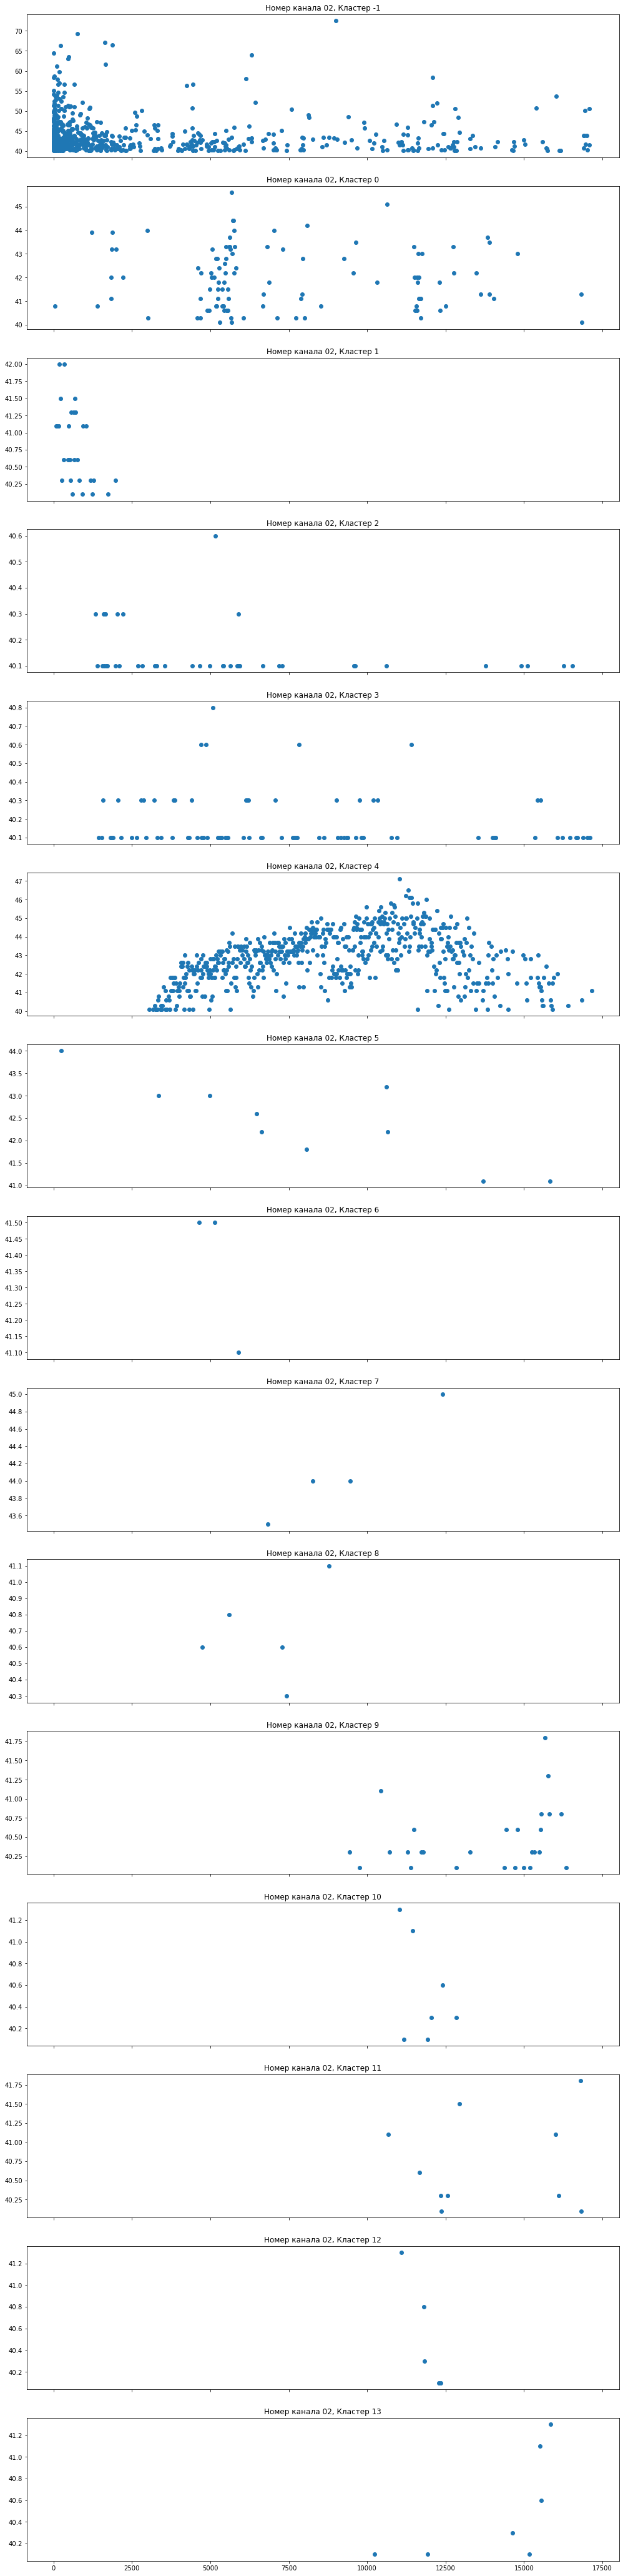

In [54]:
number = list(range(len(np.unique(clustering.labels_))))
fig, axes = plt.subplots(len(np.unique(clustering.labels_)), 1, figsize=(17, 5*len(np.unique(clustering.labels_))), sharex=True)
list_labels = list(np.unique(clustering.labels_))
for i, labels in zip(number, list_labels):
    axes[i].scatter(frame.loc[dict_index[labels]].loc[frame['Number of channel'] == '02']['Time relative'], 
               frame.loc[dict_index[labels]].loc[frame['Number of channel'] == '02']['Amplitude, dB'])
    axes[i].set_title("Номер канала 02, Кластер {}".format(labels))